# **Projet 5 : Segmentez des clients d'un site e-commerce** 

*************************************************************************************************************************************
## **Partie II : Feature Engineering(RFM)**
*************************************************************************************************************************************

## **Sommaire**

#### **1- Description génerale des données**
 - Importer les différentes librairie necessaire.
 - Installation des logiciels necessaire.
 - Charger la base de donnée totale.
 - Extraction des données nécessaires.
 - Les informations statistiques sur ensemble de données.

#### **2- Analyse exploratoire**

 - Importation des différentes tables via le site kaggle
 - Analyse de chaque table 
 - Gestion des valeurs manquantes
 - Gestion des valeurs aberrantes
 - Gestion des doublons

#### **3- Feature engineering: Analyse de la RFM**
- Trie ou jointure des variables necessaires 
- Calcul des features rfm 
- Déterminons le nombre de cluster: méthode du coude
- Scores_silhouette

#### **4- Caractéristiques des clusters basées sur la RFM**
- En utilisant les boxplots
- Mapping des noms des clusters

#### **5- Troisième feature engineering: Cluster with DBSCAN**
- Réduction du jeu de donnée afin d'éviter les bug

#### **6- Troisième feature engineering: Cluster with DBSCAN**
- Review score moyen par customer
- Réduction du jeu de donnée afin d'éviter les bug


#### **7- Contrat de Maintenance**
- Evolution de la distribution des features(RFM) dans le temps
- Évolution de la distribution des satisfaction(reviews) dans le temps
- contrat de maintenance

# 

## 1- Description génerale des données

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


###  1.1 Importer les différentes librairie necessaire

In [2]:
import sqlite3
import pandas as pd
import scipy.cluster.hierarchy as sch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from datetime import datetime, timedelta
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA, NMF

### 1.2  Installation des logiciels necessaire

#

###  1.3  Loading total database

In [3]:
# Chemin d'accès des données
db_path = r"/Users/gassuccedric/Downloads/olist.db"

# Fusion de toutes les tables pour constituer la base de donnée totale
df_base = """
             SELECT o.*, c.customer_unique_id, i.*, p.*, py.*, r.review_score, s.seller_zip_code_prefix, t.product_category_name_english
             FROM orders o
             LEFT JOIN customers c ON o.customer_id = c.customer_id
             LEFT JOIN order_items i ON o.order_id = i.order_id
             LEFT JOIN products p ON i.product_id = p.product_id
             LEFT JOIN order_pymts py ON o.order_id = py.order_id
             LEFT JOIN order_reviews r ON o.order_id = r.order_id
             LEFT JOIN sellers s ON i.seller_id = s.seller_id
             LEFT JOIN translation t ON p.product_category_name = t.product_category_name
         """
# Reconnection avec la base de donnée
conn = sqlite3.connect(db_path)
df_base_merge = pd.read_sql_query(df_base, conn)
# fermeture de la connection
conn.close()
df_base_merge.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,...,product_width_cm,index,order_id,payment_sequential,payment_type,payment_installments,payment_value,review_score,seller_zip_code_prefix,product_category_name_english
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,...,13.0,10770.0,e481f51cbdc54678b7cc49136f2d6af7,1.0,credit_card,1.0,18.12,4.0,9350.0,housewares
1,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,...,13.0,44246.0,e481f51cbdc54678b7cc49136f2d6af7,3.0,voucher,1.0,2.00,4.0,9350.0,housewares
2,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,...,13.0,91130.0,e481f51cbdc54678b7cc49136f2d6af7,2.0,voucher,1.0,18.59,4.0,9350.0,housewares
3,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,...,19.0,7652.0,53cdb2fc8bc7dce0b6741e2150273451,1.0,boleto,1.0,141.46,4.0,31570.0,perfumery
4,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,...,21.0,11176.0,47770eb9100c2d0c44946d9cf07ec65d,1.0,credit_card,3.0,179.12,5.0,14840.0,auto


### 1.4  Extraction les données nécessaires

In [4]:
# Requête pour extraire les données nécessaires

Query = """

SELECT 
    c.customer_id,
    o.order_id,
    o.order_purchase_timestamp,
    r.review_score,
    o.order_delivered_customer_date,
    oi.price + oi.freight_value AS total_price
FROM 
    customers c
JOIN 
    orders o ON c.customer_id = o.customer_id
JOIN 
    order_items oi ON o.order_id = oi.order_id
JOIN 
    order_reviews r ON o.order_id = r.order_id
WHERE 
    o.order_status = 'delivered';
"""
#oi.price + oi.freight_value AS total_price
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
Query_Necessary_data = pd.read_sql_query(Query, conn)
Query_Necessary_data.head(5)

,customer_id,order_id,order_purchase_timestamp,review_score,order_delivered_customer_date,total_price
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,4,2017-10-10 21:25:13,38.71
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,4,2018-08-07 15:27:45,141.46
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,5,2018-08-17 18:06:29,179.12
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,5,2017-12-02 00:28:42,72.20
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,5,2018-02-16 18:17:02,28.62


### 1.5 Les informations statistiques sur ensemble de données

In [5]:
Query_Necessary_data.shape

(110013, 6)

In [6]:
Query_Necessary_data.columns

Index(['customer_id', 'order_id', 'order_purchase_timestamp', 'review_score',
       'order_delivered_customer_date', 'total_price'],
      dtype='object')

In [7]:
Query_Necessary_data.describe()

,review_score,total_price
count,110013.000000,110013.000000
mean,4.081309,139.631181
std,1.347658,187.734257
min,1.000000,6.080000
25%,4.000000,55.110000
50%,5.000000,91.990000
75%,5.000000,157.340000
max,5.000000,6929.310000


In [8]:
Query_Necessary_data.dtypes

customer_id                       object
order_id                          object
order_purchase_timestamp          object
review_score                       int64
order_delivered_customer_date     object
total_price                      float64
dtype: object

In [9]:
Query_Necessary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110013 entries, 0 to 110012
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    110013 non-null  object 
 1   order_id                       110013 non-null  object 
 2   order_purchase_timestamp       110013 non-null  object 
 3   review_score                   110013 non-null  int64  
 4   order_delivered_customer_date  110005 non-null  object 
 5   total_price                    110013 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 5.0+ MB


In [10]:
Query_Necessary_data.dtypes.value_counts()

object     4
int64      1
float64    1
dtype: int64

In [11]:
Query_Necessary_data.nunique()

customer_id                      95832
order_id                         95832
order_purchase_timestamp         95317
review_score                         5
order_delivered_customer_date    95016
total_price                      28617
dtype: int64

#

## 2- Nettoyage et premier feature engineering

### 2.1 **Importation des différentes tables du site kaggle**

In [12]:
sellers_path = r"/Users/gassuccedric/Documents/OPENCLASSROOMS _24/P5/archive/olist_sellers_dataset.csv"
product_cathegory_transaction_path = r"/Users/gassuccedric/Documents/OPENCLASSROOMS _24/P5/archive/product_category_name_translation.csv"
product_path = r"/Users/gassuccedric/Documents/OPENCLASSROOMS _24/P5/archive/olist_products_dataset.csv"
orders_path = r"/Users/gassuccedric/Documents/OPENCLASSROOMS _24/P5/archive/olist_orders_dataset.csv"
orders_reviews_path = r"/Users/gassuccedric/Documents/OPENCLASSROOMS _24/P5/archive/olist_order_reviews_dataset.csv"
orders_payments_path = r"/Users/gassuccedric/Documents/OPENCLASSROOMS _24/P5/archive/olist_order_payments_dataset.csv"
orders_items_path = r"/Users/gassuccedric/Documents/OPENCLASSROOMS _24/P5/archive/olist_order_items_dataset.csv"
geolocalisation_path = r"/Users/gassuccedric/Documents/OPENCLASSROOMS _24/P5/archive/olist_geolocation_dataset.csv"
customers_path = r"/Users/gassuccedric/Documents/OPENCLASSROOMS _24/P5/archive/olist_customers_dataset.csv"

###  2.2  Analyse de chaque table

- **sellers**

In [13]:
sellers = pd.read_csv(sellers_path)
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


- **product_cathegory_transaction**

In [14]:
product_cathegory_transaction = pd.read_csv(product_cathegory_transaction_path)
product_cathegory_transaction.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


- **product**

In [15]:
product = pd.read_csv(product_path)
product.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


- **orders**

In [16]:
orders = pd.read_csv(orders_path)
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


- **orders_reviews**

In [17]:
orders_reviews = pd.read_csv(orders_reviews_path)
orders_reviews.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


- **orders_payments**

In [18]:
orders_payments = pd.read_csv(orders_payments_path)
orders_payments.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


- **orders_items**

In [19]:
orders_items = pd.read_csv(orders_items_path)
orders_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


- **Geolocalisation**

In [20]:
geolocalisation = pd.read_csv(geolocalisation_path)
geolocalisation.head(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP


- **Customers**

In [21]:
customers = pd.read_csv(customers_path)
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [22]:
# Création d'une liste contenant les différentes tables
liste_des_tables = [sellers, product_cathegory_transaction,
                    product, orders, orders_reviews,
                    orders_payments, orders_items,
                    geolocalisation, customers]

- **Dimensions des différents jeux de données**

In [23]:
 for table in liste_des_tables:
    print(table.shape)

(3095, 4)
(71, 2)
(32951, 9)
(99441, 8)
(99224, 7)
(103886, 5)
(112650, 7)
(1000163, 5)
(99441, 5)


#

### 2.3 Gestion des valeurs manquantes

In [24]:
for table in liste_des_tables:
    print(table.isna().sum().sum()/table.shape[0]/table.shape[1], 'NaN')

0.0 NaN
0.0 NaN
0.008254681193287003 NaN
0.00616948743476031 NaN
0.21006294560071873 NaN
0.0 NaN
0.0 NaN
0.0 NaN
0.0 NaN


### - On constate que les valeurs manquantes(NaN) conserne uniquement les  **product, orders, orders_reviews**

#### - Visualisation des valeurs manquantes

/var/folders/3k/tcwb4sts38vbvtmryp5mrw980000gn/T/ipykernel_14418/4018748247.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.5, 1, 0.4])  # on ajuste le layout pour inclure le titre de la figure


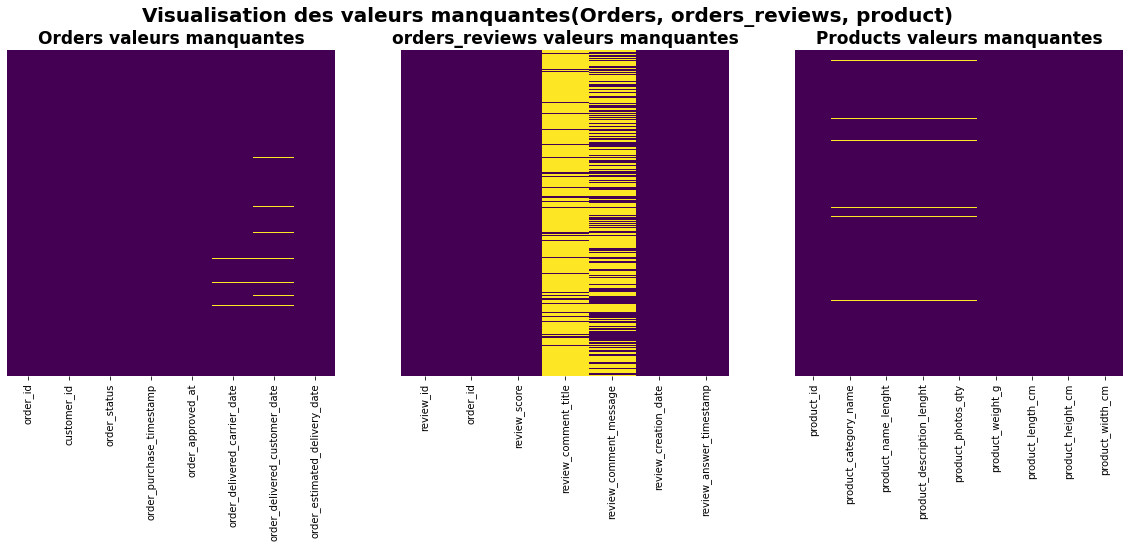

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Titre de la figure
fig.suptitle('Visualisation des valeurs manquantes(Orders, orders_reviews, product)', fontsize = 20, fontweight = 'bold')

# Heatmap pour chaque DataFrame, alignées horizontalement
sns.heatmap(orders.isnull(), cbar=False, ax=axes[0], cmap='viridis', yticklabels=False)
axes[0].set_title('Orders valeurs manquantes', fontsize = 17, fontweight = 'bold')

sns.heatmap(orders_reviews.isnull(), cbar=False, ax=axes[1], cmap='viridis', yticklabels=False)
axes[1].set_title('orders_reviews valeurs manquantes', fontsize = 17, fontweight = 'bold')

sns.heatmap(product.isnull(), cbar=False, ax=axes[2], cmap='viridis', yticklabels=False)
axes[2].set_title('Products valeurs manquantes', fontsize = 17, fontweight = 'bold')

# Afficher les graphiques
plt.tight_layout(rect=[0, 0.5, 1, 0.4])  # on ajuste le layout pour inclure le titre de la figure
plt.show()

### - **orders_reviews**

In [26]:
orders_reviews.isna().sum(axis=0)

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

- **Visualisation(NaN) des orders_reviews**

<AxesSubplot:>

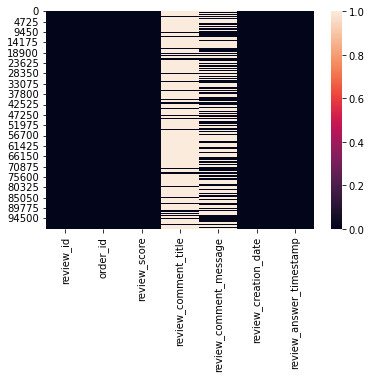

In [27]:
sns.heatmap(orders_reviews.isnull())

### On constate que les valeurs manquantes des **orders_reviews** conserne uniquement **les commentaires vides ou sans commentaire**

### - **Product**

In [28]:
product.isna().sum(axis=0)

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

#### * **product_category_name**

In [29]:
product[product['product_category_name'].isna()].sample(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
19715,e878662b68e175a58b5951e44574d5c8,NaN,NaN,NaN,NaN,2000.0,33.0,8.0,23.0
31055,3fc7f2008dc11b252c0f0e51a7bea4d6,NaN,NaN,NaN,NaN,600.0,40.0,6.0,30.0
22003,92b7afd8bcfa62ae0514184bc9e552a5,NaN,NaN,NaN,NaN,200.0,28.0,10.0,23.0


#### ** **product_description_lenght**

In [30]:
product[product['product_description_lenght'].isna()].sample(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
514,c68b419d9c6038271b85bac98adb0fc9,NaN,NaN,NaN,NaN,1000.0,16.0,14.0,30.0
14843,eaecac42c42a65691bc3662b123e884d,NaN,NaN,NaN,NaN,100.0,25.0,2.0,17.0
20692,b36f3c918c91478c4559160022d3f14e,NaN,NaN,NaN,NaN,300.0,16.0,4.0,11.0


#### *** **product_photos_qty**

In [31]:
product[product['product_photos_qty'].isna()].sample(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
7360,5455dbe20e64b08413e0f2c451e31ab9,NaN,NaN,NaN,NaN,700.0,43.0,7.0,54.0
13542,a133d679c63597e416572ee64d9d6436,NaN,NaN,NaN,NaN,400.0,16.0,92.0,16.0
3963,05cf9ac595f28386ee763c98cbc2bad0,NaN,NaN,NaN,NaN,150.0,20.0,3.0,13.0


#### **** **product_name_lenght**

In [32]:
product[product['product_name_lenght'].isna()].sample(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
26854,2ce375bc4110d978ae33e7d48d63f599,NaN,NaN,NaN,NaN,800.0,35.0,15.0,20.0
10034,44d53f1240d6332232e4393c06500475,NaN,NaN,NaN,NaN,200.0,16.0,12.0,11.0
1286,48270bcc7097939dcf14a537d7128054,NaN,NaN,NaN,NaN,1000.0,30.0,30.0,30.0


#### ***** **product_weight_g**

In [33]:
product[product['product_weight_g'].isna()].sample(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- **Visualisation(NaN) des product**

<AxesSubplot:>

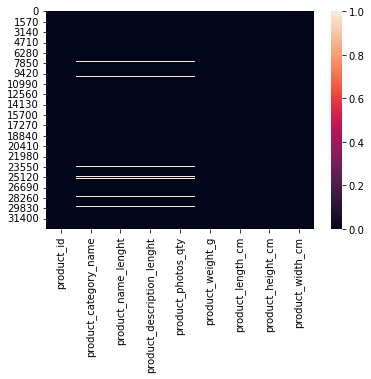

In [34]:
sns.heatmap(product.isnull())

- En résumé, on constate que les **produits** regorgent énormement de valeurs manquantes que ce soit sur **product_name_lenght**,  
 **product_photos_qty**, **product_category_name**, **product_category_name** , **product_weight_g**.

### - **Orders**

In [35]:
orders.isna().sum(axis=0)

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

- **Visualisation(NaN) des orders**

<AxesSubplot:>

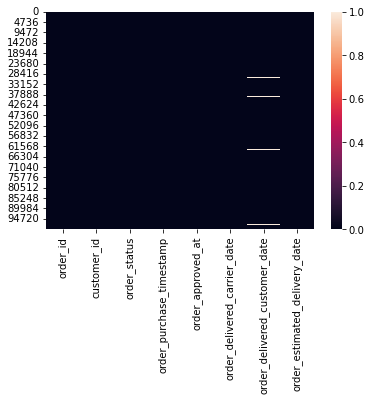

In [36]:
sns.heatmap(orders.isnull())

- **order_approved_at** : commande approuvée à
- **order_delivered_carrier_date** : date de livraison de la commande par le transporteur
- **order_delivered_customer_date** : commande livrée date client

### on constate que toute la  chaine de livraison  croit en valeur manquante(NaN) et à chaque étape, ce qui implique forcement des problèmes.

In [37]:
orders[['order_approved_at']].head(5) # commande approuvée à

,order_approved_at
0,2017-10-02 11:07:15
1,2018-07-26 03:24:27
2,2018-08-08 08:55:23
3,2017-11-18 19:45:59
4,2018-02-13 22:20:29


#

### 2.4  Gestion des doublons

In [38]:
# nombre de doublons par variable
for table in liste_des_tables:
    print(table.duplicated().sum())

0
0
0
0
0
0
0
261831
0


In [39]:
# nombre de doublons par variablefor table in liste_des_tables:
for table in liste_des_tables: 
    total_entries = len(table)
    duplicates_count = table.duplicated().sum()
    duplicates_percentage = (duplicates_count / total_entries) * 100
    print(f"Doublons: {duplicates_percentage:.2f}")

Doublons: 0.00
Doublons: 0.00
Doublons: 0.00
Doublons: 0.00
Doublons: 0.00
Doublons: 0.00
Doublons: 0.00
Doublons: 26.18
Doublons: 0.00


- La variable **geolocalisation** contient un nombre très important soit **26,18%** de valeurs manquantes.

#

## 3- Features Engineering: Analyse de la RFM(Récency, Frequency, Montary)

In [40]:
# Écrire la requête SQL

query = """
SELECT 
    c.customer_id,
    c.customer_unique_id,
    c.customer_zip_code_prefix,
    c.customer_city,
    c.customer_state,
    r.review_score,
    o.order_id,
    o.order_status,
    o.order_purchase_timestamp,
    o.order_approved_at,
    o.order_delivered_carrier_date,
    o.order_delivered_customer_date,
    o.order_estimated_delivery_date,
    oi.product_id,
    oi.seller_id,
    oi.price,
    oi.freight_value
FROM 
    customers c
JOIN 
    orders o ON c.customer_id = o.customer_id
JOIN 
    order_items oi ON o.order_id = oi.order_id
JOIN 
    order_reviews r ON o.order_id = r.order_id
WHERE
    o.order_status = 'delivered'
"""

# Exécuter la requête et charger les données dans un DataFrame
conn = sqlite3.connect(db_path)
data_base = pd.read_sql_query(query, conn)
# Fermer la connexion
conn.close()

# Afficher les premières lignes du DataFrame
data_base.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,4,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,5,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,5,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,45.00,27.20
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,5,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72


#

### Gestion des doublons

In [41]:
duplicates = data_base[data_base.duplicated(keep=False)]
duplicates_count = duplicates.shape[0]
duplicates.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value
9,494dded5b201313c64ed7f100595b95c,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,1,e6ce16cb79ec1d90b1da9085a6118aeb,delivered,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07 00:00:00,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,99.00,30.53
10,494dded5b201313c64ed7f100595b95c,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,1,e6ce16cb79ec1d90b1da9085a6118aeb,delivered,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07 00:00:00,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,99.00,30.53
51,79183cd650e2bb0d475b0067d45946ac,c77154776ead8e798c2d684205938f71,90620,porto alegre,RS,1,9faeb9b2746b9d7526aef5acb08e2aa0,delivered,2018-07-26 14:39:59,2018-07-26 14:55:10,2018-07-27 12:04:00,2018-07-31 22:26:55,2018-08-16 00:00:00,f48eb5c2fde13ca63664f0bb05f55346,f7ba60f8c3f99e7ee4042fdef03b70c4,60.00,15.52
52,79183cd650e2bb0d475b0067d45946ac,c77154776ead8e798c2d684205938f71,90620,porto alegre,RS,1,9faeb9b2746b9d7526aef5acb08e2aa0,delivered,2018-07-26 14:39:59,2018-07-26 14:55:10,2018-07-27 12:04:00,2018-07-31 22:26:55,2018-08-16 00:00:00,f48eb5c2fde13ca63664f0bb05f55346,f7ba60f8c3f99e7ee4042fdef03b70c4,60.00,15.52
57,684fa6da5134b9e4dab731e00011712d,ddf60e20e6e262e2136801ce5cd628b0,49030,aracaju,SE,1,66e4624ae69e7dc89bd50222b59f581f,delivered,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-04-03 13:28:46,2018-04-02 00:00:00,b37b72d5a56f887725c2862184b8cab8,db4350fd57ae30082dec7acbaacc17f9,22.99,22.85


In [42]:
# on supprime les doublons
data_cleaned = data_base.drop_duplicates()
data_cleaned.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,4,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,5,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,5,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,45.00,27.20
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,5,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72


#

### Valeurs manquantes

In [43]:
missing_values = data_cleaned
missing_values.isnull().sum()

customer_id                       0
customer_unique_id                0
customer_zip_code_prefix          0
customer_city                     0
customer_state                    0
review_score                      0
order_id                          0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
product_id                        0
seller_id                         0
price                             0
freight_value                     0
dtype: int64

<AxesSubplot:>

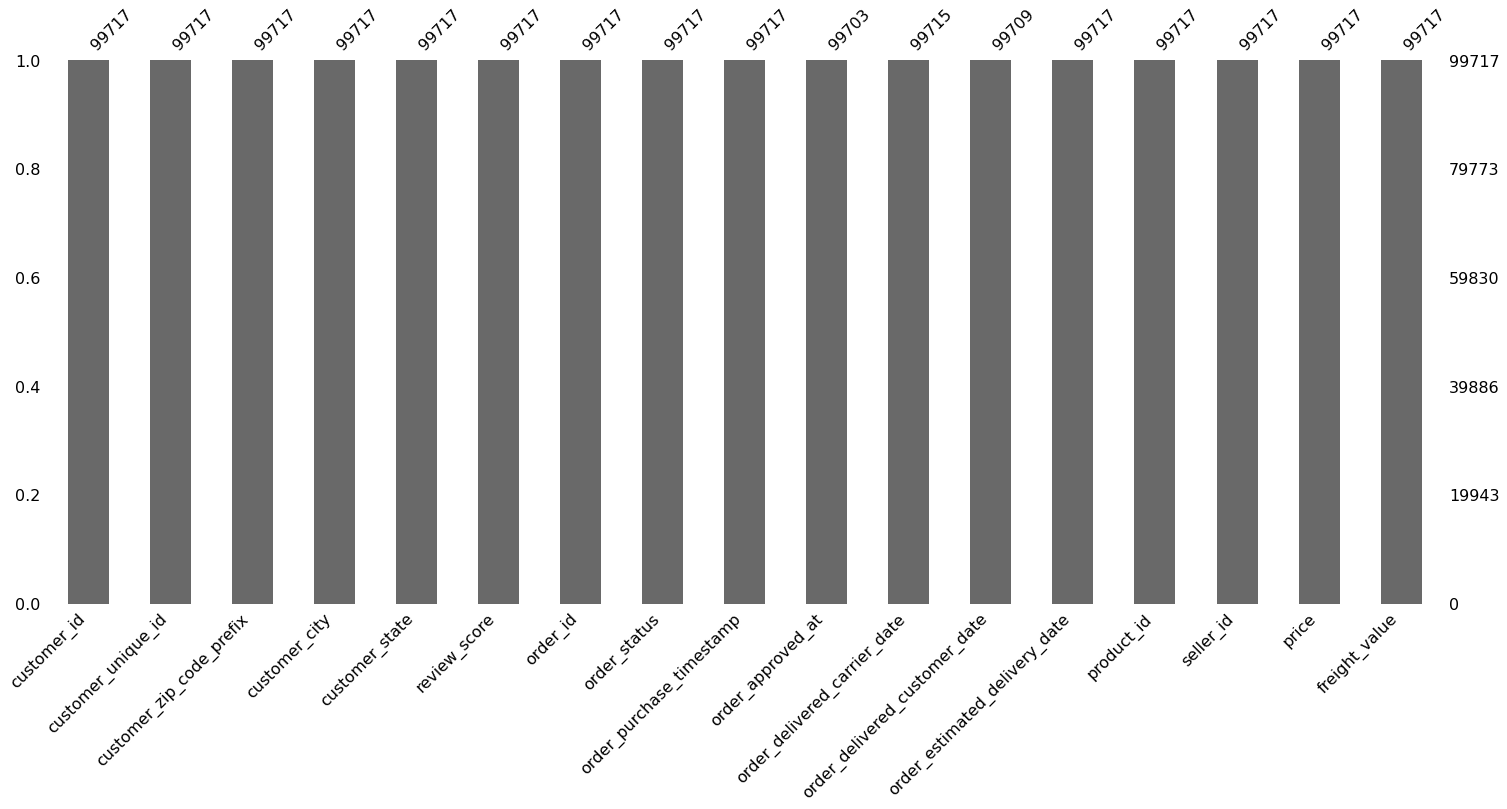

In [44]:
msno.bar(missing_values) # Visualisation des valeurs manquantes

In [45]:
# On supprime les valeurs manquantes
data_clean = missing_values.dropna()
data_clean.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,4,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,5,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,5,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,45.00,27.20
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,5,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72


### Déterminons le nombre de commande par customer

In [46]:
# Calculons le nombre de commande total par client
orders_per_customer = data_clean.groupby('customer_unique_id')['order_id'].nunique().reset_index()
orders_per_customer.rename(columns={'order_id': 'total_orders'}, inplace=True)

# Merge the total_orders back into the original dataframe
data_with_total_orders = pd.merge(data_clean, orders_per_customer, on='customer_unique_id', how='left')
data_with_total_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,total_orders
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,2
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,4,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,1
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,5,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,1
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,5,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,45.00,27.20,1
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,5,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72,1


### Calcul des features RFM

In [47]:
# Convertir la colonne 'order_purchase_timestamp' en datetime
data_with_total_orders['order_purchase_timestamp'] = pd.to_datetime(data_with_total_orders['order_purchase_timestamp'])

# Calcul de la date la plus récente pour la base de la récence
current_date = data_with_total_orders['order_purchase_timestamp'].max() + pd.DateOffset(days=1)

# Calcul de RFM
rfm = data_with_total_orders.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (current_date - x.max()).days,  # Récence
    'order_id': 'count',  # Fréquence
    'price': 'sum'  # Montant
}).rename(columns={'order_purchase_timestamp': 'Recency',
                   'order_id': 'Frequency',
                   'price': 'MonetaryValue'})

rfm.head()

,Recency,Frequency,MonetaryValue
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
0000f46a3911fa3c0805444483337064,537,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
0004aac84e0df4da2b147fca70cf8255,288,1,180.00


In [48]:
rfmDBS = rfm

# 

## 4- Etude  des clusters

### **4.1 - Méthode kmeans**

- **Nombres de clusters: méthode des coudes**

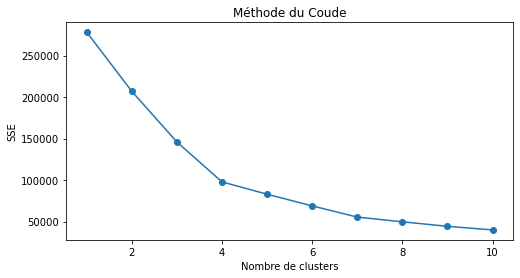

In [49]:
# Création d'un objet scaler
scaler = StandardScaler()

# Normalisation des données RFM
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'MonetaryValue']])

# Calcul de la somme des carrés des distances pour différents nombres de clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10 ,random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Tracer la courbe SSE pour voir le "coude"
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Méthode du Coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE')
plt.show()

- **Scores_silhouette**

Silhouette Score for 2 clusters: 0.66
Silhouette Score for 3 clusters: 0.45
Silhouette Score for 4 clusters: 0.48
Silhouette Score for 5 clusters: 0.49
Silhouette Score for 6 clusters: 0.42


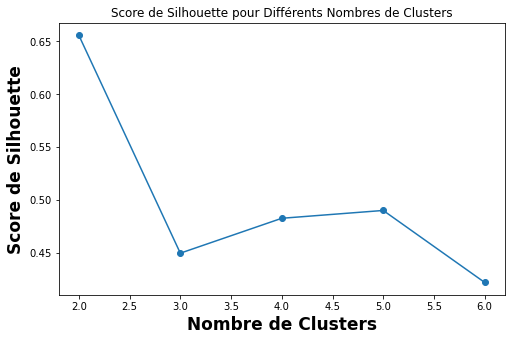

In [50]:
silhouette_scores = []

# Essayer différentes valeurs pour le nombre de clusters
for k in range(2, 7):  # Commencer à 2 car la silhouette n'est pas définie pour un seul cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, clusters)
    silhouette_scores.append(score)
    print(f"Silhouette Score for {k} clusters: {score:.2f}")

# Visualiser les scores de silhouette
plt.figure(figsize=(8, 5))
plt.plot(range(2, 7), silhouette_scores, marker='o')
plt.title('Score de Silhouette pour Différents Nombres de Clusters')
plt.xlabel('Nombre de Clusters', fontsize = 17, fontweight = 'bold')
plt.ylabel('Score de Silhouette', fontsize = 17, fontweight = 'bold')
plt.show()

- Le nombre optimal de **cluster** est estimé à **5** avec un **score_silhoutte** de **0,49**

In [52]:
rfm_scaled[:5]

array([[-0.82430723, -0.21971065, -0.0146185 ],
       [-0.80464292, -0.21971065, -0.57762158],
       [ 1.96147025, -0.21971065, -0.32350938],
       [ 0.54563982, -0.21971065, -0.54166039],
       [ 0.32933239, -0.21971065,  0.2394937 ]])

In [53]:
# Application du KMeans
kmeans = KMeans(n_clusters= 5, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)
rfm['Cluster_Kmeans'] = clusters

**- Caractéristique des clusters basé sur la RFM**

- Boxplots

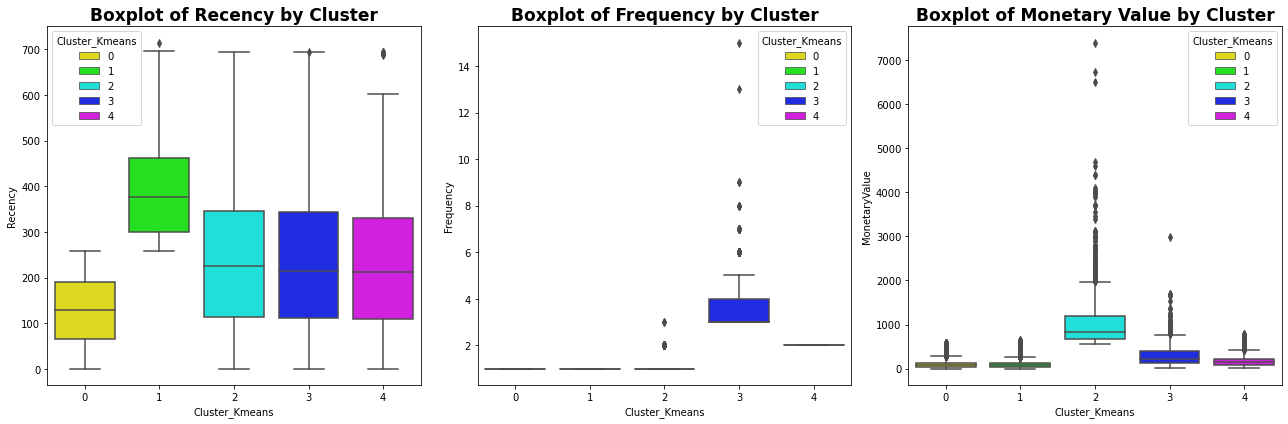

In [54]:
# Définir la palette de couleurs
palette = sns.color_palette("hsv", n_colors=len(rfm['Cluster_Kmeans'].unique()))

# Créer les boxplots pour chaque variable RFM
plt.figure(figsize=(18, 6))

# Boxplot pour Recency
plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster_Kmeans', y='Recency', data=rfm, hue='Cluster_Kmeans', palette=palette, dodge=False)
plt.title('Boxplot of Recency by Cluster', fontsize=17, fontweight='bold')

# Boxplot pour Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster_Kmeans', y='Frequency', data=rfm, hue='Cluster_Kmeans', palette=palette, dodge=False)
plt.title('Boxplot of Frequency by Cluster', fontsize=17, fontweight='bold')

# Boxplot pour MonetaryValue
plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster_Kmeans', y='MonetaryValue', data=rfm, hue='Cluster_Kmeans', palette=palette, dodge=False)
plt.title('Boxplot of Monetary Value by Cluster', fontsize=17, fontweight='bold')

plt.tight_layout()
plt.show()

**<span style="color: blue;"> cluster 0</span>** : Les clients ayant commander **plus récemment** sont **moins fréquents** et ont un **très faible budget**.

**<span style="color: blue;"> cluster 1</span>** : Les clients ayant commander **récement** sont **moins fréquentes** et ont un **budget important**.

**<span style="color: blue;"> cluster 2</span>** : Les clients ayant commander **depuis longtemps** sont **moins fréquentes** et ont un **très faible budget**.

**<span style="color: blue;"> cluster 3</span>** : Les clients ayant commander **récement** sont **plus fréquentes** et ont un **faible budget**.

**<span style="color: blue;"> cluster 4</span>** : Les clients ayant commander **récement** sont **fréquentes** et ont un **très faible budget**.

- **Mapping des noms des clusters**

In [105]:
rfm_string = rfm

# Dictionnaire de mapping des noms des clusters
cluster_names = {
                    0: "A réactiver",
                    1: "Loyaux",
                    2: "Perdus",
                    3: "Champions",
                    4: "Loyalistes potentiels"
                }

# Remplacement des valeurs numériques par des noms
rfm_string['Cluster_string'] = rfm_string['Cluster_Kmeans'].replace(cluster_names)
rfm_string = rfm_string.drop(columns = "Cluster_Kmeans")
rfm_string.head()

,Recency,Frequency,MonetaryValue,Cluster_string
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,A réactiver
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,A réactiver
0000f46a3911fa3c0805444483337064,537,1,69.00,Loyaux
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,Loyaux
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,Loyaux


- **Pourcentage des différents clusters**

In [57]:
# Pourcentage des différents clusters
percentage_cluster = rfm_string['Cluster_string'].value_counts()
percentage_cluster

A réactiver              48931
Loyaux                   35855
Loyalistes potentiels     4616
Perdus                    2428
Champions                  903
Name: Cluster_string, dtype: int64

In [58]:
percentage_cluster = rfm_digit['Cluster_string'].value_counts(normalize=True)
percentage_cluster

A réactiver              0.527655
Loyaux                   0.386648
Loyalistes potentiels    0.049777
Perdus                   0.026183
Champions                0.009738
Name: Cluster_string, dtype: float64

#

- **Application de T_SNE : Réduction des dimensions**

In [59]:
# Configuration t-SNE avec les différents paramètres et init explicite
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42, init='random')

# Application de t-SNE aux caractéristiques RFM standardisées
tsne_result = tsne.fit_transform(rfm_scaled)

# Convertir t-SNE en dataframe
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])

# Application de K-Means et ajout des clusters
clusters = kmeans.fit_predict(rfm_scaled)
tsne_df['Kmeans_Cluster'] = clusters

# Affichage des premières lignes du DataFrame
tsne_df.head()

,TSNE1,TSNE2,Kmeans_Cluster
0,1.530941,-32.368698,0
1,6.826026,19.069679,0
2,22.069777,8.040294,1
3,-52.333969,28.260830,1
4,-16.850056,4.812237,1


- **Visualisation de la repartition des clusters**

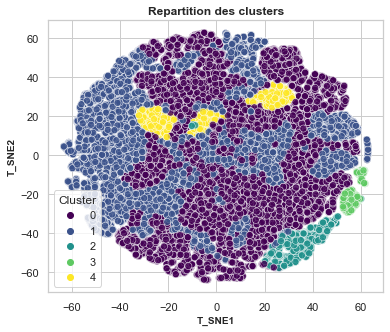

In [60]:
# Set the style
sns.set(style="whitegrid")

# Visualiser un nuage de point
plt.figure(figsize=(6, 5))
scatter_plot = sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Kmeans_Cluster', palette='viridis', s=50, alpha=0.8)
scatter_plot.set_title('Repartition des clusters', fontsize = 12, fontweight = 'bold')
scatter_plot.set_xlabel('T_SNE1', fontsize = 10, fontweight = 'bold')
scatter_plot.set_ylabel('T_SNE2', fontsize = 10, fontweight = 'bold')
plt.legend(title='Cluster')
plt.show()

#

## 4.2 - Clustering Hiérachique: Méthode clustering Agglomerative

### Afin d'éviter les bug nous travaillerons sur 20000 données

In [61]:
# Pour éviter les bug travaillons sur les 20000 données aléatoires
Cluster_Agglomerative = rfm[["Recency","Frequency","MonetaryValue"]]
Cluster_Agglomeratives = Cluster_Agglomerative.sample(20000)
# Normalise 
Cluster_Agglomeratives_scaled = scaler.fit_transform(Cluster_Agglomeratives)

### Silouhettes selons le type de lien, dendogramme et clustermap

#### - **Critères de liens** : permet de mesurer la distance entre deux clusters

- **Single Linkage** : Distance minimale entre deux points de clusters différents.
- **Complete Linkage** : Distance maximale entre deux points de clusters différents.
- **Average Linkage** : Moyenne des distances entre tous les points des deux clusters.
- **Ward’s Method** : Minimise la variance totale intra-cluster.

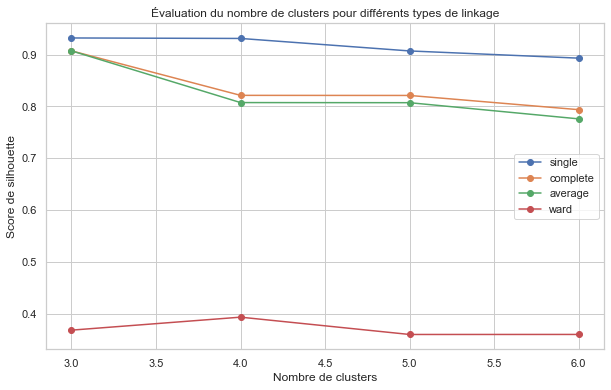

In [62]:
# Types de linkage à tester
linkage_types = ['single', 'complete', 'average', 'ward']

# Nombre de clusters souhaité
clusters = [3, 4, 5, 6]

# Liste pour stocker les scores de silhouette pour chaque type de linkage
silhouettes_scores = {linkage: [] for linkage in linkage_types}

for linkage in linkage_types:
    for i in clusters:
        # Modèle de clustering hiérarchique agglomératif
        agg_cluster = AgglomerativeClustering(n_clusters=i, linkage=linkage)
        agg_cluster.fit(Cluster_Agglomeratives)
        silh_score = silhouette_score(Cluster_Agglomeratives, agg_cluster.labels_)
        silhouettes_scores[linkage].append(silh_score)

# graphique
plt.figure(figsize=(10, 6))
for linkage in linkage_types:
    plt.plot(clusters, silhouettes_scores[linkage], marker='o', label=linkage)

plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Évaluation du nombre de clusters pour différents types de linkage')
plt.legend()
plt.show()

- **Réalisation du dendrogram**

<span style="color: blue;"> - **Linkage ward** </span>

/Users/gassuccedric/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


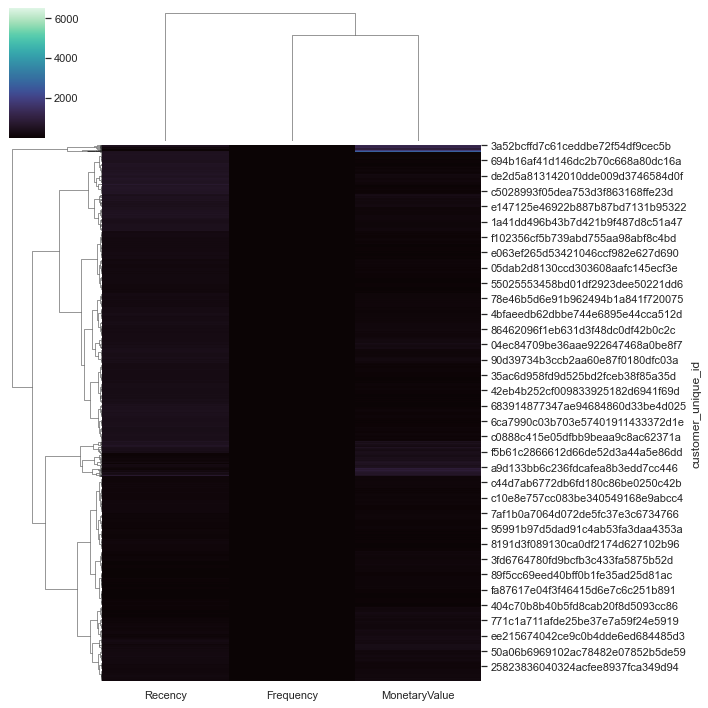

In [63]:
sns.clustermap(Cluster_Agglomeratives, cmap='mako', method="ward")

- **Ling ward**

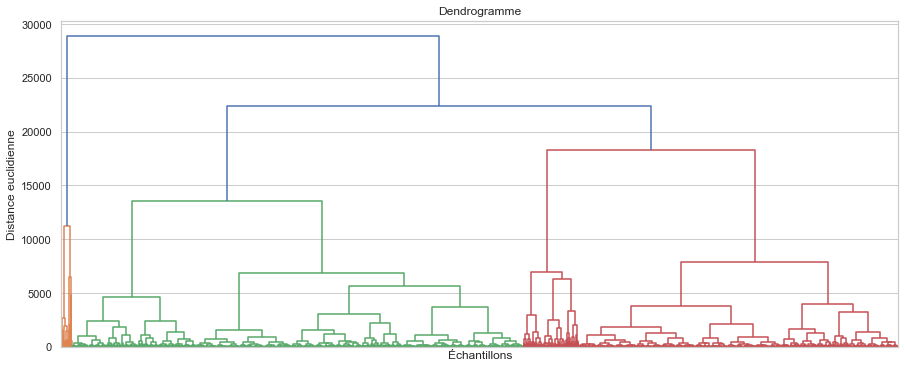

In [64]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Calcul de la matrice de distance
distance_matrix = linkage(Cluster_Agglomeratives, method='ward')

# Dendrogramm
plt.figure(figsize=(15, 6))
dendrogram(distance_matrix)
plt.title('Dendrogramme')
plt.xlabel('Échantillons')
plt.ylabel('Distance euclidienne')
plt.xticks([])
plt.show()

**On constate que ce lien met en valeur 3 types de clients**

- **Link average**

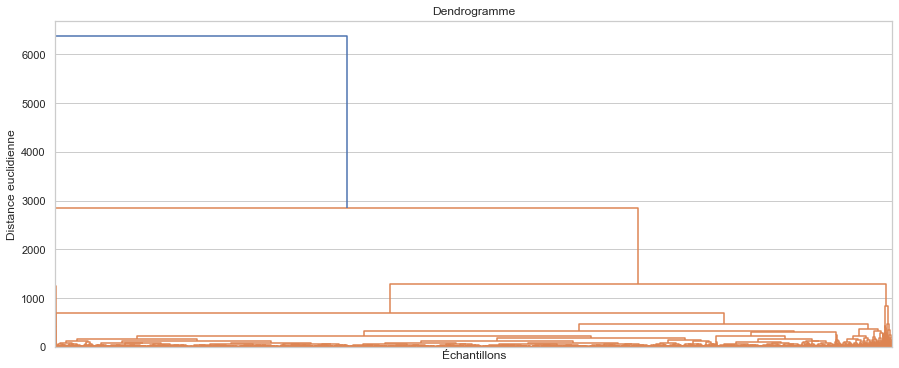

In [65]:
# Matrice de distance
distance_matrix = linkage(Cluster_Agglomeratives, method='average')

# dendrogramme
plt.figure(figsize=(15, 6))
dendrogram(distance_matrix)
plt.title('Dendrogramme')
plt.xlabel('Échantillons')
plt.ylabel('Distance euclidienne')
plt.xticks([])
plt.show()

- **Link single**

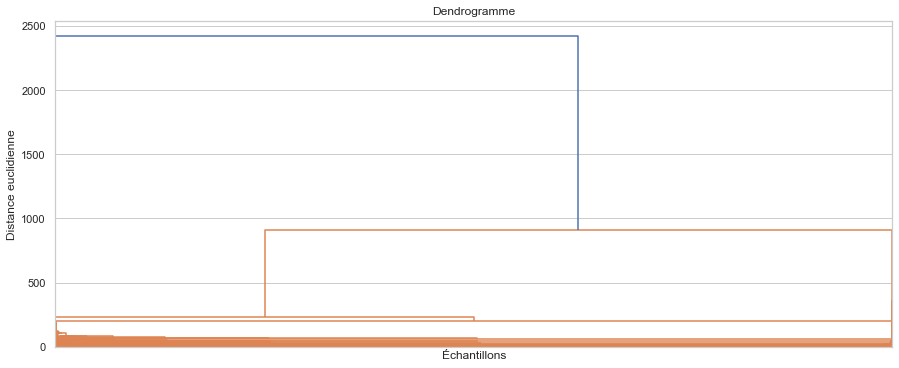

In [66]:
# Matrice de distance
distance_matrix = linkage(Cluster_Agglomeratives, method='single')

# dendrogramme
plt.figure(figsize=(15, 6))
dendrogram(distance_matrix)
plt.title('Dendrogramme')
plt.xlabel('Échantillons')
plt.ylabel('Distance euclidienne')
plt.xticks([])
plt.show()

- **Link complete**

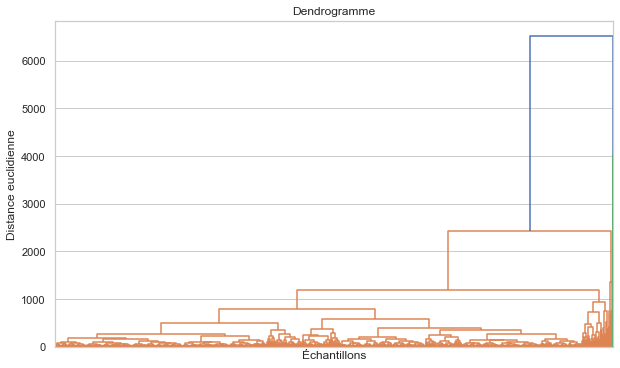

In [67]:
# Matrice de distance
distance_matrix = linkage(Cluster_Agglomeratives, method='complete')

# dendrogramme
plt.figure(figsize=(10, 6))
dendrogram(distance_matrix)
plt.title('Dendrogramme')
plt.xlabel('Échantillons')
plt.ylabel('Distance euclidienne')
plt.xticks([])
plt.show()

En observant les silouhettes, le cluster map et les dendogramme on en déduit que : 
- Qu'il y a en moyenne 2 type de client  mais que dans le deuxième groupe (en vert dans **complete et ward**) il y a deux sous groupe 
- Le ward dans la silouhette capte 3 types de client

- **Score**

In [68]:
# Entrainement du Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage='ward')
labels = agg_clust.fit_predict(Cluster_Agglomeratives_scaled)
Cluster_Agglomeratives['cluster_agglo'] = labels

# silhouette score
silhouette_avg = round(silhouette_score(Cluster_Agglomeratives_scaled, labels),2)
print("Le score de silhouette est:", silhouette_avg )   

Le score de silhouette est: 0.48


- **Visualisation Agglomerative clustering**

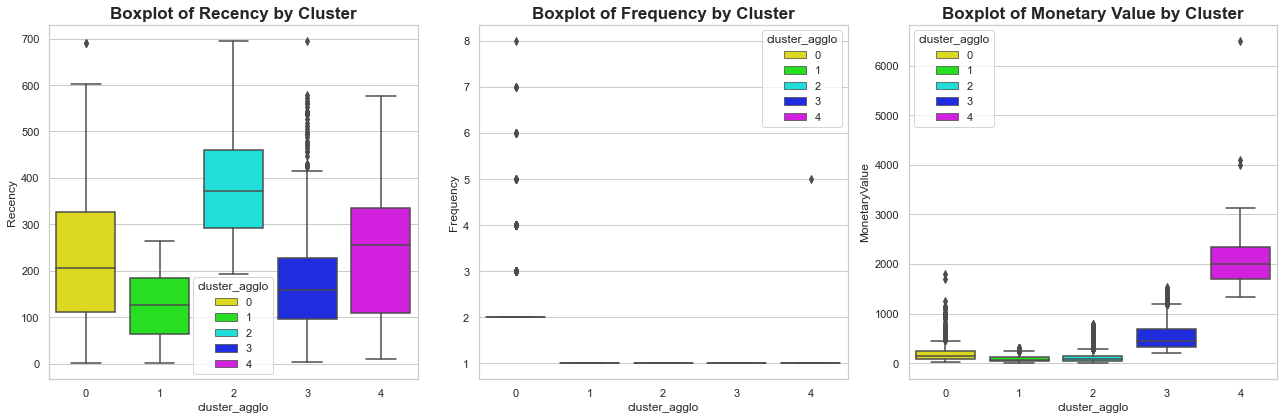

In [69]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Définir la palette de couleurs
palette = sns.color_palette("hsv", n_colors=len(Cluster_Agglomeratives['cluster_agglo'].unique()))

# Créer les boxplots pour chaque variable RFM
plt.figure(figsize=(18, 6))

# Boxplot pour Recency
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_agglo', y='Recency', data=Cluster_Agglomeratives, hue='cluster_agglo', palette=palette, dodge=False)
plt.title('Boxplot of Recency by Cluster', fontsize=17, fontweight='bold')

# Boxplot pour Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_agglo', y='Frequency', data=Cluster_Agglomeratives, hue='cluster_agglo', palette=palette, dodge=False)
plt.title('Boxplot of Frequency by Cluster', fontsize=17, fontweight='bold')

# Boxplot pour MonetaryValue
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_agglo', y='MonetaryValue', data=Cluster_Agglomeratives, hue='cluster_agglo', palette=palette, dodge=False)
plt.title('Boxplot of Monetary Value by Cluster', fontsize=17, fontweight='bold')

plt.tight_layout()
plt.show()

/var/folders/3k/tcwb4sts38vbvtmryp5mrw980000gn/T/ipykernel_14418/1109899243.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sc, ax=ax, pad=0.2,shrink=0.8)


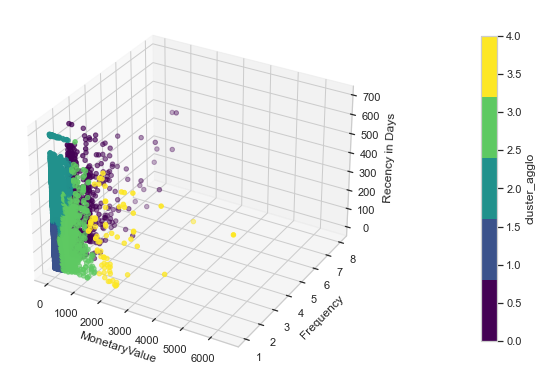

In [70]:
# Créer une figure 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Obtenir les couleurs pour chaque cluster
colors = plt.cm.get_cmap("viridis", Cluster_Agglomeratives['cluster_agglo'].nunique())

# Tracer les points      
sc = ax.scatter(
    Cluster_Agglomeratives['MonetaryValue'], 
    Cluster_Agglomeratives['Frequency'], 
    Cluster_Agglomeratives['Recency'], 
    c=Cluster_Agglomeratives['cluster_agglo'], 
    cmap=colors )

# Ajouter des labels aux axes
ax.set_xlabel('MonetaryValue')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency in Days')

# Ajouter une légende
cbar = plt.colorbar(sc, ax=ax, pad=0.2,shrink=0.8)
cbar.set_label('cluster_agglo')

plt.show()

- **Projection t_SNE**

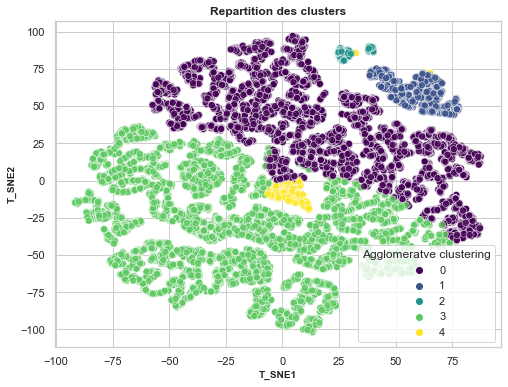

In [71]:
# Configuration t-SNE avec les différents paramètres et init explicite
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42, init='random')

# Application de t-SNE aux caractéristiques RFM standardisées
tsne_Agglo = tsne.fit_transform(Cluster_Agglomeratives_scaled)

# Convertir t-SNE en dataframe
tsne_df_agglo = pd.DataFrame(data=tsne_Agglo, columns=['TSNE1', 'TSNE2'])

# Application de K-Means et ajout des clusters
clusterss = kmeans.fit_predict(Cluster_Agglomeratives_scaled)
tsne_df_agglo['Agglo_Cluster'] = clusterss

# Set the style
sns.set(style="whitegrid")

# Visualiser un nuage de point
plt.figure(figsize=(8, 6))
scatter_plot = sns.scatterplot(data=tsne_df_agglo, x='TSNE1', y='TSNE2', hue='Agglo_Cluster', palette='viridis', s=50, alpha=0.8)
scatter_plot.set_title('Repartition des clusters', fontsize = 12, fontweight = 'bold')
scatter_plot.set_xlabel('T_SNE1', fontsize = 10, fontweight = 'bold')
scatter_plot.set_ylabel('T_SNE2', fontsize = 10, fontweight = 'bold')
plt.legend(title='Agglomeratve clustering')
plt.show()

#

##  4.3 - Cluster with DBSCAN

In [73]:
# rfm associée
rfmDBS = data_with_total_orders.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (current_date - x.max()).days,  # Récence
    'order_id': 'count',  # Fréquence
    'price': 'sum'  # Montant
}).rename(columns={'order_purchase_timestamp': 'Recency',
                   'order_id': 'Frequency',
                   'price': 'MonetaryValue'})

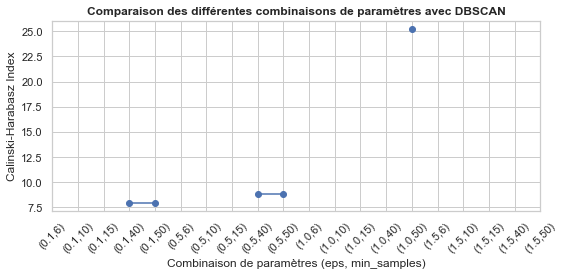

In [74]:
# Hyperparamètres(eps,min_samples) du clustering DBSCAN
eps_values = [0.1, 0.5, 1.0, 1.5]    #[0.1,0.2,0.5, 1.0, 1.5]
min_samples_values = [6, 10, 15,40,50]          #[6, 24, 60,70,100]  # Modifiez le min_samples pour spécifier au minimum 3 clusters
scores = []

# Calculer l'indice de Calinski-Harabasz pour chaque combinaison de paramètres
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(rfmDBS)
        unique_labels = np.unique(labels)
        if len(unique_labels) >= 3 and len(unique_labels) <= 6 :
            score = calinski_harabasz_score(rfmDBS, labels)
            scores.append(score)
        else:
            scores.append(np.nan)  

# Tracer les scores en fonction des combinaisons de paramètres
plt.figure(figsize=(8,4))
plt.plot(scores, marker='o')
plt.xticks(np.arange(len(eps_values) * len(min_samples_values)), [f'({eps},{min_samples})' for eps in eps_values for min_samples in min_samples_values], rotation=45)
plt.xlabel('Combinaison de paramètres (eps, min_samples)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Comparaison des différentes combinaisons de paramètres avec DBSCAN', fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
dbscan = DBSCAN(eps=0.2, min_samples= 24)
labelS = dbscan.fit_predict(rfmDBS)
print(np.unique(labelS))

[-1  0  1  2  3]


In [76]:
dbscan2 = DBSCAN(eps=0.5, min_samples=60)
labelS2 = dbscan.fit_predict(rfmDBS)
print(np.unique(labelS2))

[-1  0  1  2  3]


### Visualisation

/var/folders/3k/tcwb4sts38vbvtmryp5mrw980000gn/T/ipykernel_14418/449593913.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sc, ax=ax, pad=0.2,shrink=0.8)


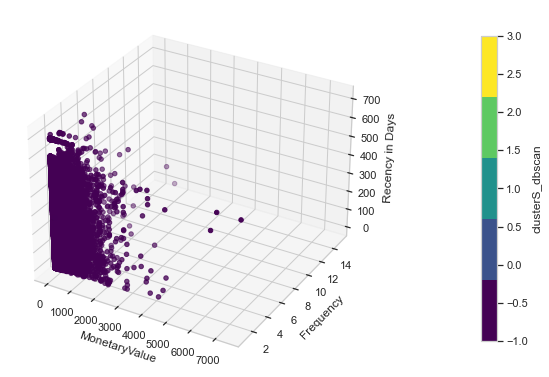

In [77]:
dbscan_clustered = pd.DataFrame(rfmDBS, columns=['Recency', 'Frequency', 'MonetaryValue'])
dbscan_clustered['clusterS_dbscan'] = labelS

# Créer une figure 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Obtenir les couleurs pour chaque cluster
colors = plt.cm.get_cmap("viridis", dbscan_clustered['clusterS_dbscan'].nunique())

# Tracer les points
sc = ax.scatter(
    dbscan_clustered['MonetaryValue'], 
    dbscan_clustered['Frequency'], 
    dbscan_clustered['Recency'], 
    c=dbscan_clustered['clusterS_dbscan'], 
    cmap=colors
)

# Ajouter des labels aux axes
ax.set_xlabel('MonetaryValue')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency in Days')

# Ajouter une légende
cbar = plt.colorbar(sc, ax=ax, pad=0.2,shrink=0.8)
cbar.set_label('clusterS_dbscan')

plt.show()

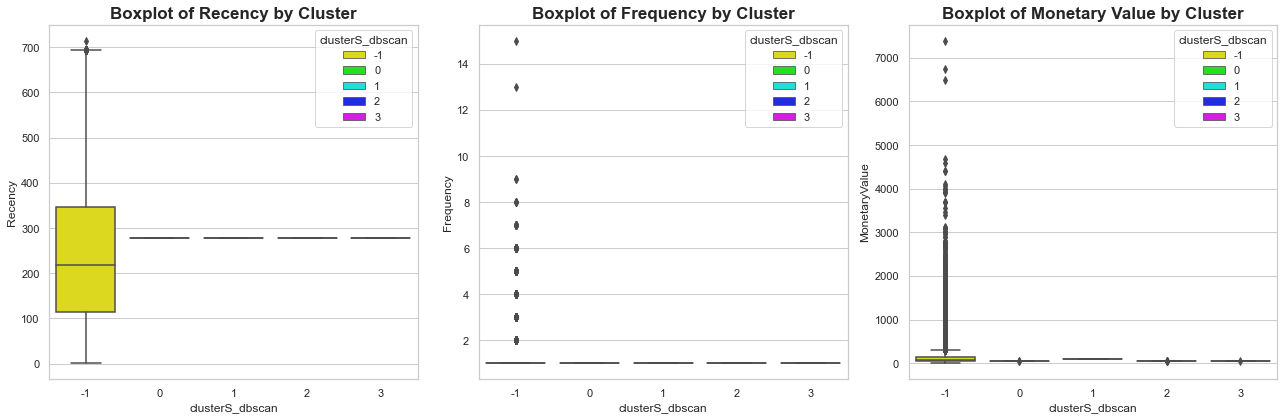

In [78]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Définir la palette de couleurs
palette = sns.color_palette("hsv", n_colors=len(dbscan_clustered['clusterS_dbscan'].unique()))

# Créer les boxplots pour chaque variable RFM
plt.figure(figsize=(18, 6))

# Boxplot pour Recency
plt.subplot(1, 3, 1)
sns.boxplot(x='clusterS_dbscan', y='Recency', data=dbscan_clustered, hue='clusterS_dbscan', palette=palette, dodge=False)
plt.title('Boxplot of Recency by Cluster', fontsize=17, fontweight='bold')

# Boxplot pour Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x='clusterS_dbscan', y='Frequency', data=dbscan_clustered, hue='clusterS_dbscan', palette=palette, dodge=False)
plt.title('Boxplot of Frequency by Cluster', fontsize=17, fontweight='bold')

# Boxplot pour MonetaryValue
plt.subplot(1, 3, 3)
sns.boxplot(x='clusterS_dbscan', y='MonetaryValue', data=dbscan_clustered, hue='clusterS_dbscan', palette=palette, dodge=False)
plt.title('Boxplot of Monetary Value by Cluster', fontsize=17, fontweight='bold')

plt.tight_layout()
plt.show()

- **Score sihouette**

In [79]:
# Création d'un objet scaler
scaler = StandardScaler()
# Normalisation des données RFM
rfmDBS_scaled = scaler.fit_transform(rfmDBS[['Recency', 'Frequency', 'MonetaryValue']])
# Vérifier si des clusters ont été trouvés
if len(set(labelS)) > 1:  # La silhouette score n'est pas définie si un seul cluster est trouvé
    silhouette_avg = round(silhouette_score(rfmDBS_scaled, labelS), 2)
    print("Le score de silhouette est:", silhouette_avg)
else:
    print("Impossible de calculer le score de silhouette : un seul cluster détecté.")

Le score de silhouette est: -0.39


### Visualisation des scores des différents modèles

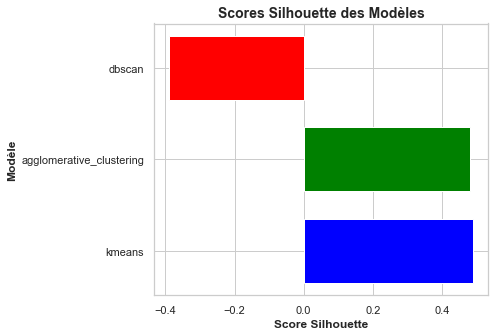

In [198]:
# Modèle 
modèles = ["kmeans", "agglomerative_clustering", "dbscan"]
scores_silhouette = [0.49, 0.48, -0.39]
couleurs = ['blue', 'green', 'red']

# Plot
plt.figure(figsize=(6, 5))
plt.barh(modèles, scores_silhouette, color=couleurs, height=0.7)
plt.xlabel("Score Silhouette", fontweight = 'bold', fontsize = 12)
plt.ylabel("Modèle", fontweight = 'bold', fontsize = 12)
plt.title("Scores Silhouette des Modèles", fontweight = 'bold', fontsize = 14)
plt.show()

# 

## **5- Analyse des Reviews_scores**

### - Calcul de la RFM

In [113]:
# Convertir la colonne 'order_purchase_timestamp' en datetime
data_with_total_orders['order_purchase_timestamp'] = pd.to_datetime(data_with_total_orders['order_purchase_timestamp'])

# Calcul de la date la plus récente pour la base de la récence
current_date = data_with_total_orders['order_purchase_timestamp'].max() + pd.DateOffset(days=1)

# Calcul de RFM
rfm_reviews = data_with_total_orders.groupby('customer_unique_id').agg({
            'order_purchase_timestamp': lambda x: (current_date - x.max()).days,  # Récence
            'order_id': 'count',  # Fréquence
            'price': 'sum',  # Montant
            'review_score': 'mean'
    
}).rename(columns={'order_purchase_timestamp': 'Recency',
                   'order_id': 'Frequency',
                   'price': 'MonetaryValue',
                   'review_score': 'Review_scores'})
rfm_reviews.head() 

,Recency,Frequency,MonetaryValue,Review_scores
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4.0
0000f46a3911fa3c0805444483337064,537,1,69.00,3.0
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,4.0
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,5.0


In [114]:
rfm_reviews.shape

(92733, 4)

- **Histogramme**

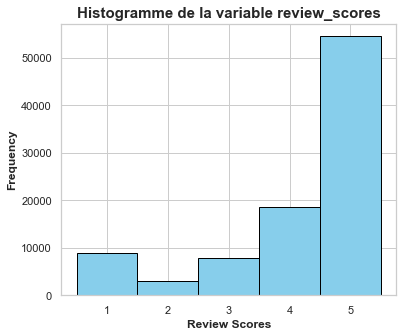

In [115]:
# histogramme de la variable review_scores
plt.figure(figsize=(6, 5))
plt.hist(rfm_reviews['Review_scores'], bins=range(int(rfm_reviews['Review_scores'].min()), int(rfm_reviews['Review_scores'].max()) + 2), align='left', color='Skyblue', edgecolor='black')
plt.title('Histogramme de la variable review_scores', fontsize = 15, fontweight = 'bold')
plt.xlabel('Review Scores', fontsize = 12, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 12, fontweight = 'bold')
plt.grid(True)
plt.show()

## 5.1 - Etude des clusters : Méthode kmeans

- **Nombres de clusters: méthode des coudes**

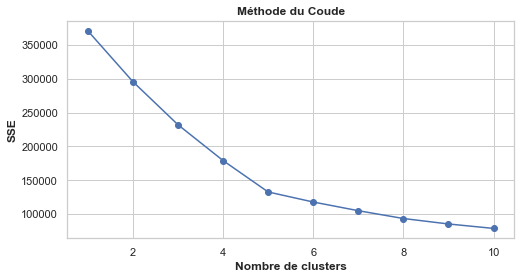

In [116]:
# Création d'un objet scaler
scaler = StandardScaler()

# Normalisation des données RFM
RFM_reviews_scaled = scaler.fit_transform(rfm_reviews)

# Calcul de la somme des carrés des distances pour différents nombres de clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10 ,random_state=42)
    kmeans.fit(RFM_reviews_scaled)
    sse.append(kmeans.inertia_)

# Tracer la courbe SSE pour voir le "coude"
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Méthode du Coude', fontweight= 'bold')
plt.xlabel('Nombre de clusters', fontweight= 'bold')
plt.ylabel('SSE', fontweight= 'bold')
plt.show()

- **Score_silhouette**

Silhouette Score for 2 clusters: 0.39
Silhouette Score for 3 clusters: 0.40
Silhouette Score for 4 clusters: 0.38
Silhouette Score for 5 clusters: 0.41
Silhouette Score for 6 clusters: 0.41


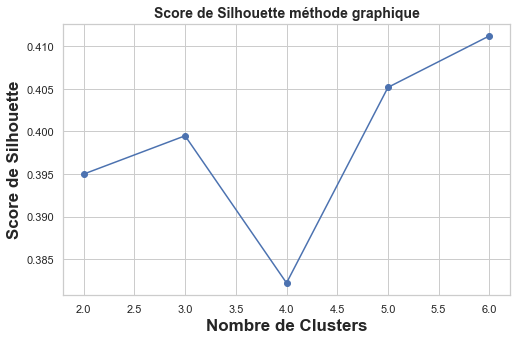

In [117]:
silhouette_scores = []

# Essayer différentes valeurs pour le nombre de clusters
for k in range(2, 7):  # Commencer à 2 car la silhouette n'est pas définie pour un seul cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters_reviews = kmeans.fit_predict(RFM_reviews_scaled)
    score = silhouette_score(RFM_reviews_scaled, clusters_reviews)
    silhouette_scores.append(score)
    print(f"Silhouette Score for {k} clusters: {score:.2f}")

# Visualiser les scores de silhouette
plt.figure(figsize=(8, 5))
plt.plot(range(2, 7), silhouette_scores, marker='o')
plt.title('Score de Silhouette méthode graphique', fontsize = 14, fontweight = 'bold')
plt.xlabel('Nombre de Clusters', fontsize = 17, fontweight = 'bold')
plt.ylabel('Score de Silhouette', fontsize = 17, fontweight = 'bold')
plt.show()

- On conclut que le meilleur score de silhouette a une valeur de **0.41** correspondant à **5 clusters**

In [123]:
RFM_reviews = rfm_reviews
# Application du KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_reviews = kmeans.fit_predict(RFM_reviews_scaled)
RFM_reviews['ClusterREVIEWS'] = clusters_reviews

In [119]:
RFM_reviews.shape

(92733, 5)

###  **- Caractéristiques des clusters**

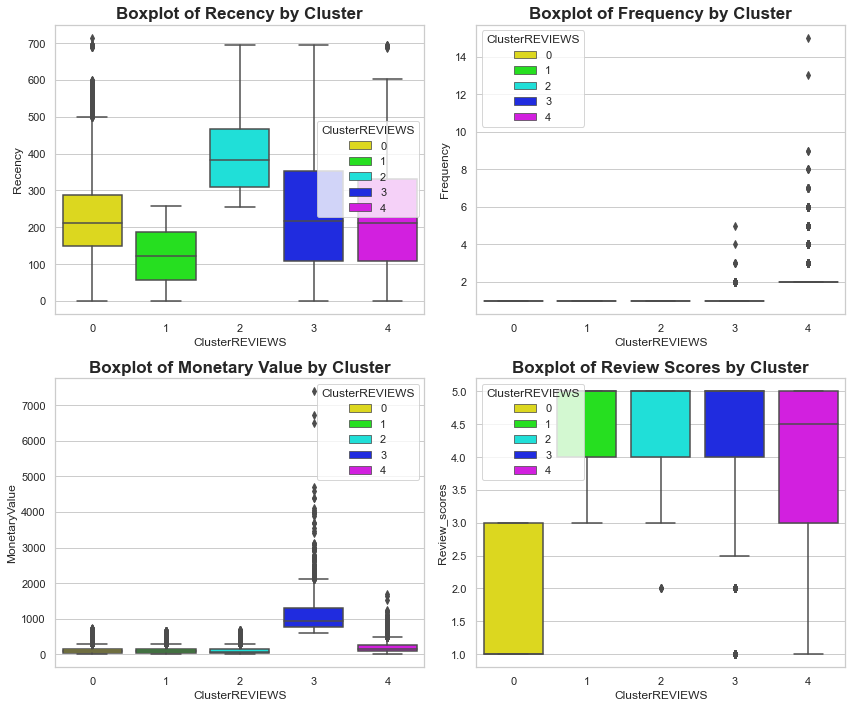

In [174]:
# Définir la palette de couleurs
palette = sns.color_palette("hsv", n_colors=len(rfm_reviews['ClusterREVIEWS'].unique()))

# Créer les boxplots pour chaque variable RFM
plt.figure(figsize=(12, 10))

# Boxplot pour Recency
plt.subplot(2, 2, 1)  # Première case de la grille 2x2
sns.boxplot(x='ClusterREVIEWS', y='Recency', data=rfm_reviews, hue='ClusterREVIEWS', palette=palette, dodge=False)
plt.title('Boxplot of Recency by Cluster', fontsize=17, fontweight='bold')

# Boxplot pour Frequency
plt.subplot(2, 2, 2)  # Deuxième case de la grille 2x2
sns.boxplot(x='ClusterREVIEWS', y='Frequency', data=rfm_reviews, hue='ClusterREVIEWS', palette=palette, dodge=False)
plt.title('Boxplot of Frequency by Cluster', fontsize=17, fontweight='bold')

# Boxplot pour MonetaryValue
plt.subplot(2, 2, 3)  # Troisième case de la grille 2x2
sns.boxplot(x='ClusterREVIEWS', y='MonetaryValue', data=rfm_reviews, hue='ClusterREVIEWS', palette=palette, dodge=False)
plt.title('Boxplot of Monetary Value by Cluster', fontsize=17, fontweight='bold')

# Boxplot pour Review_scores
plt.subplot(2, 2, 4)  # Quatrième case de la grille 2x2
sns.boxplot(x='ClusterREVIEWS', y='Review_scores', data=rfm_reviews, hue='ClusterREVIEWS', palette=palette, dodge=False)
plt.title('Boxplot of Review Scores by Cluster', fontsize=17, fontweight='bold')

plt.tight_layout()
plt.show()

**<span style="color: blue;"> cluster 0</span>** : Les clients ayant commander **récemment** sont **très moins fréquents**, ont un **très faible budget** et donnent généralement des **mauvais reviews**.

**<span style="color: blue;"> cluster 1</span>** : Les clients ayant commander **plus récemment** sont **très moins fréquentes**, ont un **très faible budget** et donnent généralement des **très bon reviews**.
 
**<span style="color: blue;"> cluster 2</span>** : Les clients ayant commander **depuis longtemps** sont **très moins fréquentes**, ont un **très faible budget**, et donnent généralement des **très bon review**.

**<span style="color: blue;"> cluster 3</span>** : Les clients ayant commander **récement** sont **très moins fréquentes**, ont un **budget moyen**, et donnent généralement des **très bon reviews**.

**<span style="color: blue;"> cluster 4</span>** : Les clients ayant commander **récement** sont **fréquentes** ,ont un **très faible budget** et donnent généralement des **bon reviews**..

In [125]:
#cluster numérique
cluster_digit = RFM_reviews
cluster_digit.head()

,Recency,Frequency,MonetaryValue,Review_scores,ClusterREVIEWS
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,5.0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4.0,1
0000f46a3911fa3c0805444483337064,537,1,69.00,3.0,2
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,4.0,2
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,5.0,2


### - Mapping des noms des clusters

In [126]:
mapping_clusters = RFM_reviews
# Dictionnaire de mapping des noms des clusters
cluster_names = {
                    0: "A réactiver",
                    1: "Loyaux",
                    2: "Perdus",
                    3: "Loyalistes potentiels",
                    4: "Champions"
                }
# Remplacement des valeurs numériques par des noms
mapping_clusters['Cluster_MapReview'] = mapping_clusters['ClusterREVIEWS'].replace(cluster_names)
mapping_clusters = mapping_clusters.drop(columns = "ClusterREVIEWS")
mapping_clusters.head()

,Recency,Frequency,MonetaryValue,Review_scores,Cluster_MapReview
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,5.0,Loyaux
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4.0,Loyaux
0000f46a3911fa3c0805444483337064,537,1,69.00,3.0,Perdus
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,4.0,Perdus
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,5.0,Perdus


- **Pourcentage des différents clusters**

In [127]:
# Pourcentage des différents clusters
percentage_cluster = mapping_clusters['Cluster_MapReview'].value_counts()
percentage_cluster

Loyaux                   40201
Perdus                   30480
A réactiver              14613
Champions                 5517
Loyalistes potentiels     1922
Name: Cluster_MapReview, dtype: int64

In [130]:
percentage_cluster = round(mapping_clusters['Cluster_MapReview'].value_counts(normalize=True),2)
percentage_cluster

Loyaux                   0.43
Perdus                   0.33
A réactiver              0.16
Champions                0.06
Loyalistes potentiels    0.02
Name: Cluster_MapReview, dtype: float64

In [129]:
mapping_clusters.shape

(92733, 5)

- **Projection T_SNE**

In [131]:
# Configuration t-SNE avec les différents paramètres et init explicite
tsne_review = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42, init='random')

# Application de t-SNE aux caractéristiques RFM standardisées
tsne_results = tsne_review.fit_transform(RFM_reviews_scaled)

# Convertir t-SNE en dataframe
tsne_data = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])

# Application de K-Means et ajout des clusters
clusters_Tsne = kmeans.fit_predict(RFM_reviews_scaled)
tsne_data['Cluster_tsne'] = clusters_Tsne

tsne_data.head()

,TSNE1,TSNE2,Cluster_tsne
0,32.788437,-5.778324,1
1,-1.465892,-47.273251,1
2,-7.936362,57.087425,2
3,-20.198959,6.285326,2
4,3.541620,-10.041510,2


- **Visualisation de la repartition des clusters**

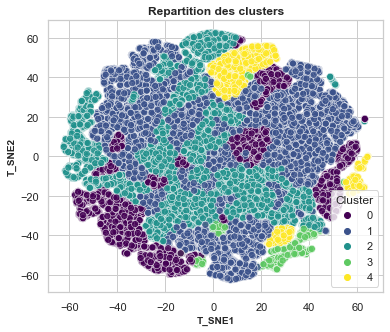

In [132]:
# Set the style
sns.set(style="whitegrid")

# Visualiser un nuage de point
plt.figure(figsize=(6, 5))
scatter_plot = sns.scatterplot(data=tsne_data, x='TSNE1', y='TSNE2', hue='Cluster_tsne', palette='viridis', s=50, alpha=0.8)
scatter_plot.set_title('Repartition des clusters', fontsize = 12, fontweight = 'bold')
scatter_plot.set_xlabel('T_SNE1', fontsize = 10, fontweight = 'bold')
scatter_plot.set_ylabel('T_SNE2', fontsize = 10, fontweight = 'bold')
plt.legend(title='Cluster')
plt.show()

### 5.2 - Méthode clustering Agglomerative

### Afin d'éviter les bug, nous réduirons les données à 20000 

In [133]:
# Pour éviter les bug travaillons sur les 20000 données aléatoires
review_Agglomerative = rfm_reviews[["Recency","Frequency","MonetaryValue","Review_scores"]]
reviews_Agglomeratives = review_Agglomerative.sample(20000)
# Normalise 
reviews_Agglomeratives_scaled = scaler.fit_transform(reviews_Agglomeratives)

### Silouhettes selons le type de lien, dendogramme et clustermap

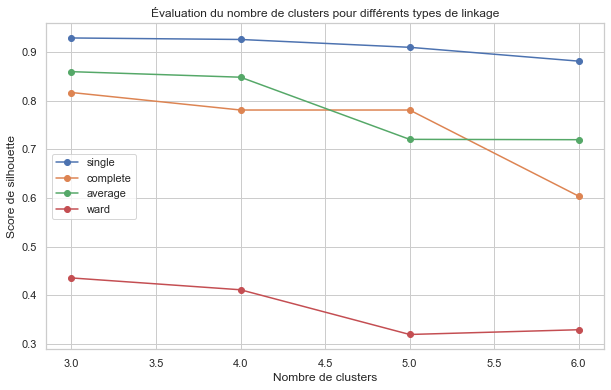

In [134]:
# Types de linkage à tester
linkage_types = ['single', 'complete', 'average', 'ward']

# Nombre de clusters souhaité
clusters = [3, 4, 5, 6]

# Liste pour stocker les scores de silhouette pour chaque type de linkage
silhouettes_scores = {linkage: [] for linkage in linkage_types}

for linkage in linkage_types:
    for i in clusters:
        # Modèle de clustering hiérarchique agglomératif
        agg_cluster = AgglomerativeClustering(n_clusters=i, linkage=linkage)
        agg_cluster.fit(reviews_Agglomeratives)
        silh_score = silhouette_score(reviews_Agglomeratives, agg_cluster.labels_)
        silhouettes_scores[linkage].append(silh_score)

# graphique
plt.figure(figsize=(10, 6))
for linkage in linkage_types:
    plt.plot(clusters, silhouettes_scores[linkage], marker='o', label=linkage)

plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Évaluation du nombre de clusters pour différents types de linkage')
plt.legend()
plt.show()

### **Réalisation du dendrogram**

<span style="color: red;"> **1 - Linkage Ward** </span>

/Users/gassuccedric/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


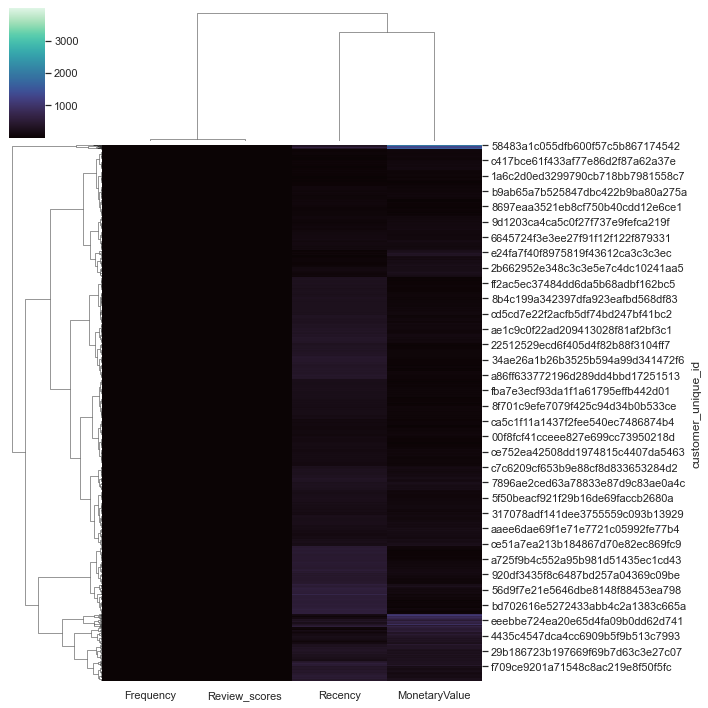

In [135]:
sns.clustermap(reviews_Agglomeratives, cmap='mako', method = "ward")

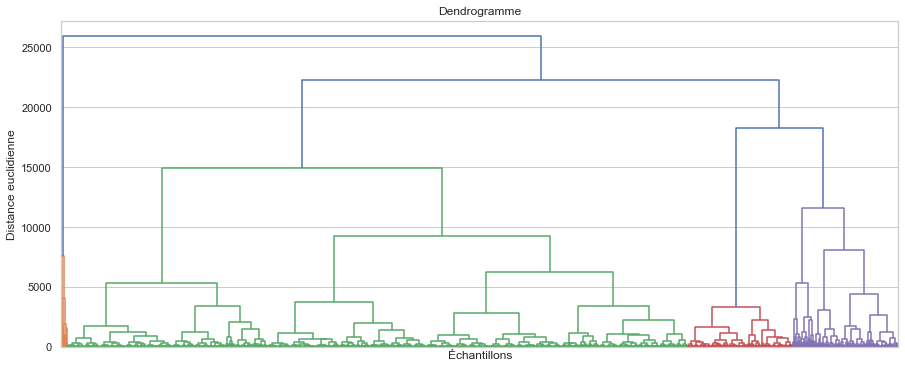

In [136]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Calcul de la matrice de distance
distance_matrix = linkage(reviews_Agglomeratives, method='ward')

# Dendrogramm
plt.figure(figsize=(15, 6))
dendrogram(distance_matrix)
plt.title('Dendrogramme')
plt.xlabel('Échantillons')
plt.ylabel('Distance euclidienne')
plt.xticks([])
plt.show()

### On constate que ce lien met en valeur 3 types de clients(bleu, rouge, orange)

<span style="color: red;"> **2 - Linkage Single** </span>

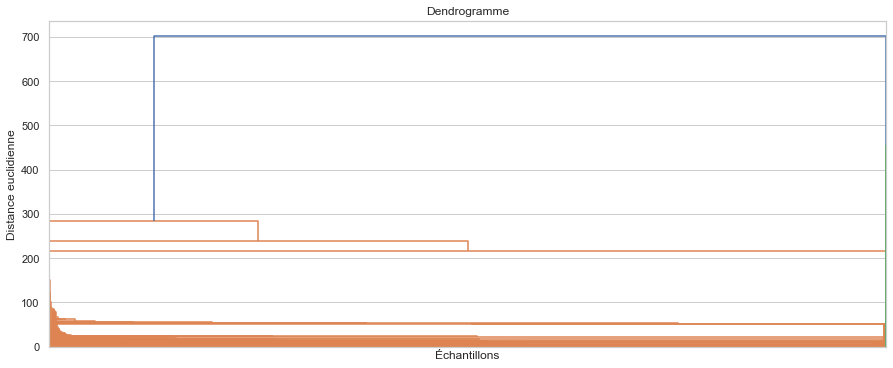

In [137]:
# Calcul de la matrice de distance
distance_matrix = linkage(reviews_Agglomeratives, method='single')

# Dendrogramm
plt.figure(figsize=(15, 6))
dendrogram(distance_matrix)
plt.title('Dendrogramme')
plt.xlabel('Échantillons')
plt.ylabel('Distance euclidienne')
plt.xticks([])
plt.show()

<span style="color: red;"> **3 - Linkage Complete** </span>

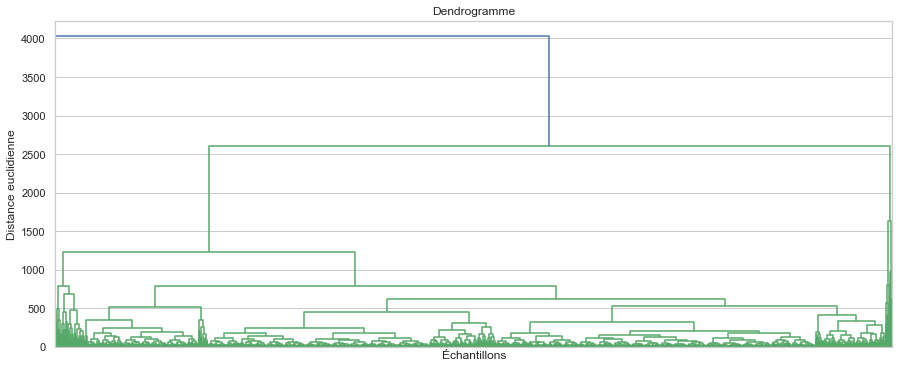

In [138]:
# Calcul de la matrice de distance
distance_matrix = linkage(reviews_Agglomeratives, method='complete')

# Dendrogramm
plt.figure(figsize=(15, 6))
dendrogram(distance_matrix)
plt.title('Dendrogramme')
plt.xlabel('Échantillons')
plt.ylabel('Distance euclidienne')
plt.xticks([])
plt.show()

- **Score_silhouette**

In [139]:
# Entrainement du Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage='ward')
labels = agg_clust.fit_predict(reviews_Agglomeratives_scaled)
reviews_Agglomeratives['review_aggloCluster'] = labels

# silhouette score
silhouette_avg = round(silhouette_score(reviews_Agglomeratives_scaled, labels),2)
print("Le score de silhouette est:", silhouette_avg )   

Le score de silhouette est: 0.36


# 

### 5.3 - Cluster with DBSCAN

In [145]:
# Calcul de RFM
rfm_DBS = data_with_total_orders.groupby('customer_unique_id').agg({
            'order_purchase_timestamp': lambda x: (current_date - x.max()).days,  # Récence
            'order_id': 'count',  # Fréquence
            'price': 'sum',  # Montant
            'review_score': 'mean'
    
}).rename(columns={'order_purchase_timestamp': 'Recency',
                   'order_id': 'Frequency',
                   'price': 'MonetaryValue',
                   'review_score': 'Review_scores'})

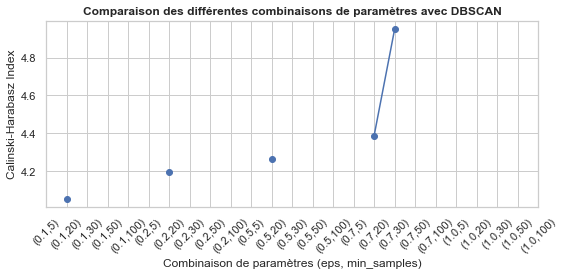

In [150]:
# Hyperparamètres(eps,min_samples) du clustering DBSCAN
eps_values = [0.1, 0.2 ,0.5, 0.7, 1.0 ]    
min_samples_values = [5, 20 ,30 ,50 ,100] #[6, 24, 60,70,100]  # Modifiez le min_samples pour spécifier au minimum 3 clusters
scores = []

# Calinski-Harabasz : est un score calculé pour chaque configuration de clusters. Un pic dans le graphique 
# suggère un nombre optimal de clusters.

# Calculer l'indice de Calinski-Harabasz pour chaque combinaison de paramètres
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(rfm_DBS)
        unique_labels = np.unique(labels)
        if len(unique_labels) >= 3 and len(unique_labels) <= 6 :
            score = calinski_harabasz_score(rfm_DBS, labels)
            scores.append(score)
        else:
            scores.append(np.nan)  

# Tracer les scores en fonction des combinaisons de paramètres
plt.figure(figsize=(8,4))
plt.plot(scores, marker='o')
plt.xticks(np.arange(len(eps_values) * len(min_samples_values)), [f'({eps},{min_samples})' for eps in eps_values for min_samples in min_samples_values], rotation=45)
plt.xlabel('Combinaison de paramètres (eps, min_samples)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Comparaison des différentes combinaisons de paramètres avec DBSCAN', fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

In [157]:
dbscan0 = DBSCAN(eps=0.7, min_samples= 30)
labelS0 = dbscan0.fit_predict(rfm_DBS)
print(np.unique(labelS0))

[-1  0  1]


In [159]:
dbscan1 = DBSCAN(eps=0.1, min_samples= 20)
labelS1 = dbscan1.fit_predict(rfm_DBS)
print(np.unique(labelS1))

[-1  0  1]


- **Score sihouette**

In [199]:

# Vérifier si des clusters ont été trouvés
if len(set(labelS0)) > 1:  # La silhouette score n'est pas définie si un seul cluster est trouvé
    silhouette_avg = round(silhouette_score(RFM_reviews_scaled, labelS0), 2)
    print("Le score de silhouette est:", silhouette_avg)
else:
    print("Impossible de calculer le score de silhouette : un seul cluster détecté.")

Le score de silhouette est: -0.33


### Projection T_SNE

In [180]:
# Configuration t-SNE avec les différents paramètres et init explicite
tsne_review = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42, init='random')

# Application de t-SNE aux caractéristiques RFM standardisées
tsne_results = tsne_review.fit_transform(RFM_reviews_scaled)

# Convertir t-SNE en dataframe
tsne_data = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])

# Application de K-Means et ajout des clusters
tsne_data['DBSCAN_Cluster'] = labelS0

tsne_data.head()

,TSNE1,TSNE2,DBSCAN_Cluster
0,32.788437,-5.778324,-1
1,-1.465892,-47.273251,-1
2,-7.936362,57.087425,-1
3,-20.198959,6.285326,-1
4,3.541620,-10.041510,-1


- **Visualisation de la répartition des clusters**

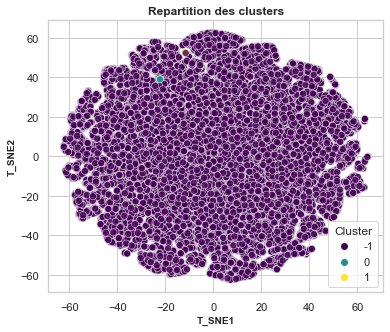

In [181]:
# Set the style
sns.set(style="whitegrid")

# Visualiser un nuage de point
plt.figure(figsize=(6, 5))
scatter_plot = sns.scatterplot(data=tsne_data, x='TSNE1', y='TSNE2', hue='DBSCAN_Cluster', palette='viridis', s=50, alpha=0.8)
scatter_plot.set_title('Repartition des clusters', fontsize = 12, fontweight = 'bold')
scatter_plot.set_xlabel('T_SNE1', fontsize = 10, fontweight = 'bold')
scatter_plot.set_ylabel('T_SNE2', fontsize = 10, fontweight = 'bold')
plt.legend(title='Cluster')
plt.show()

### Ce modèle n'est pas efficace

### - Visualisation des différents scores 

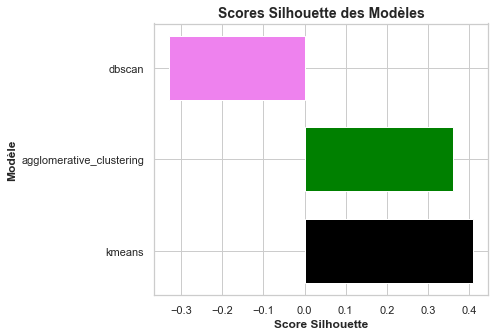

In [202]:
# Modèle 
modèles = ["kmeans", "agglomerative_clustering", "dbscan"]
scores_silhouette = [0.41, 0.36, -0.33]
couleurs = ['black', 'green', 'violet']

# Plot
plt.figure(figsize=(6, 5))
plt.barh(modèles, scores_silhouette, color=couleurs, height=0.7)
plt.xlabel("Score Silhouette", fontweight = 'bold', fontsize = 12)
plt.ylabel("Modèle", fontweight = 'bold', fontsize = 12)
plt.title("Scores Silhouette des Modèles", fontweight = 'bold', fontsize = 14)
plt.show()

# 

## 7-  Contrat de maintenance

**- Determinons dans un premier temps, la date d'achat de la première et dernière commande dans le jeu de donnée total**

In [ ]:
# Première commande effuctué
data_with_total_orders["order_purchase_timestamp"].min()

In [ ]:
# dernière commande effectué
data_with_total_orders["order_purchase_timestamp"].max()

- On constate que sur l'echelle du temps, la première commande a été passé en **Septembre 2016** et la dernière en **Aout 2018**.

### **- Evolution  de ARI dans le temps**

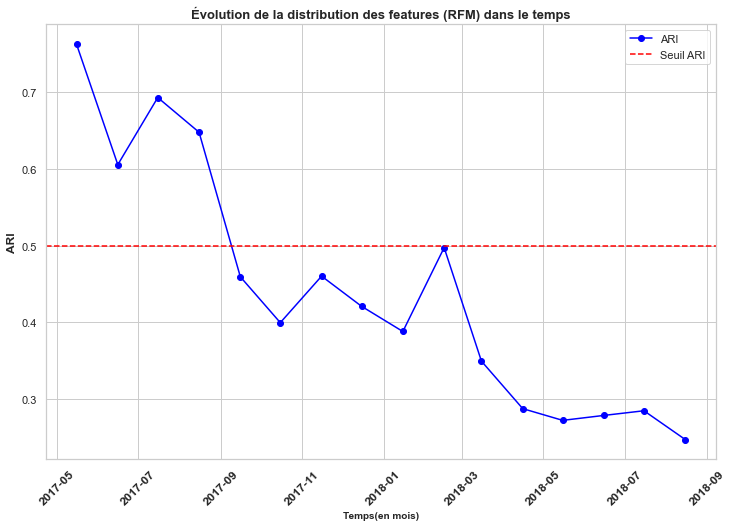

In [186]:
# Convertir les timestamps en datetime
data_clean['order_purchase_timestamp'] = pd.to_datetime(data_clean['order_purchase_timestamp'])

# Définir la date de début pour les calculs RFM
T0 = data_clean['order_purchase_timestamp'].min() + pd.DateOffset(months=8)

# Dictionnaire de temps pour le tracé
temps = {i: T0 + pd.DateOffset(months=i) for i in range(18)}

# Filtrer les données initiales pour inclure les commandes jusqu'à T0 inclus
initial_data = data_clean[data_clean['order_purchase_timestamp'] <= T0]

# Calculer RFM initial
rfm0 = initial_data.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (T0 - x.max()).days,
    'order_id': 'count',
    'price': 'sum'
}).rename(columns={
    'order_purchase_timestamp': 'Recency', 
    'order_id': 'Frequency', 
    'price': 'MonetaryValue'
})

# Normaliser les données RFM
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm0[['Recency', 'Frequency', 'MonetaryValue']])

# Clustering initial avec K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
M0 = kmeans.fit(rfm_normalized)
rfm0['Cluster'] = M0.labels_

# Boucle temporelle pour les calculs et ARI
end_date = data_clean['order_purchase_timestamp'].max()
current_date = T0
aris = []
time_labels = []

while current_date <= end_date:
    # Enregistrement de la date courante pour l'étiquette
    month_index = (current_date - T0).days // 30  # Calcul de l'index du mois
    time_labels.append(temps.get(month_index, current_date))
    
    next_month = current_date + pd.DateOffset(days=30)
    month_data = data_clean[data_clean['order_purchase_timestamp'] <= next_month]
    current_rfm = month_data.groupby('customer_unique_id').agg({
        'order_purchase_timestamp': lambda x: (next_month - x.max()).days,
        'order_id': 'count',
        'price': 'sum'
    }).rename(columns={'order_purchase_timestamp': 'Recency', 'order_id': 'Frequency', 'price': 'MonetaryValue'})

    if not current_rfm.empty:
        current_rfm_normalized = scaler.transform(current_rfm[['Recency', 'Frequency', 'MonetaryValue']])       
        model = KMeans(n_clusters=5, random_state=42)
        Mi = model.fit(current_rfm_normalized)
        Ci_new = Mi.labels_
        Ci_init = M0.predict(current_rfm_normalized)
        
        # Calcul de ARI
        ari = adjusted_rand_score(Ci_new, Ci_init)
        aris.append(ari)
    
    current_date += timedelta(days=30)

# Afficher le graphique de l'ARI
plt.figure(figsize=(12, 8))
plt.plot(time_labels, aris, marker='o', color="blue", label='ARI')
plt.axhline(y=0.5, color='red', linestyle='--', label='Seuil ARI')
plt.xlabel('Temps(en mois)', fontweight='bold', fontsize=10)
plt.ylabel('ARI', fontweight='bold', fontsize=12)
plt.title('Évolution de la distribution des features (RFM) dans le temps', fontweight='bold', fontsize=13)
plt.xticks(rotation=45,fontweight='bold', fontsize=12) 
plt.legend()
plt.grid(True)
plt.show()

### **INTERPRETATION**

**1- Établir un seuil pour l'ARI**
On défint un seuil en dessous duquel la similarité des clusters est jugée insuffisante, indiquant qu'un réentraînement 
pourrait être nécessaire. Nous l'avons fixé à 0,5.

**2- Surveiller l'évolution de l'ARI**

l'évolution de l'ARI au fil des mois. Si l'ARI chute en dessous du seuil établi, cela peut 
indiquer que les clusters ont divergé de manière significative par rapport à la période initiale, et que les données ont 
peut-être évolué(nouvelles tendances d'achat, introduction de nouveaux produits... .).


**3- Réentraîner le modèle**

On constate que la courbe passe en dessous du seuil en 4 reprises.Cela suggère qu'il est temps de réentraîner le modèle après un changement important de niveau(pente entre deux mois) en passant le seuil au premier instant ou elle traverse son seuil, dans notre cas c'est en **NOVENBRE 2017**. Réentraîner le modèle permettra 
d'ajuster les clusters pour refléter les changements dans les données et maintenir la pertinence du modèle pour de bonne décisions                

**4- Analyser les causes des changements**
                 
Il faut tout de même analyser les causes sous-jacentes des changements dans les clusters pour comprendre les dynamiques des données. Cela peut 
inclure l'analyse des caractéristiques des clients, des changements dans les comportements d'achat, ou l'introduction de 
nouveaux produits ou services.

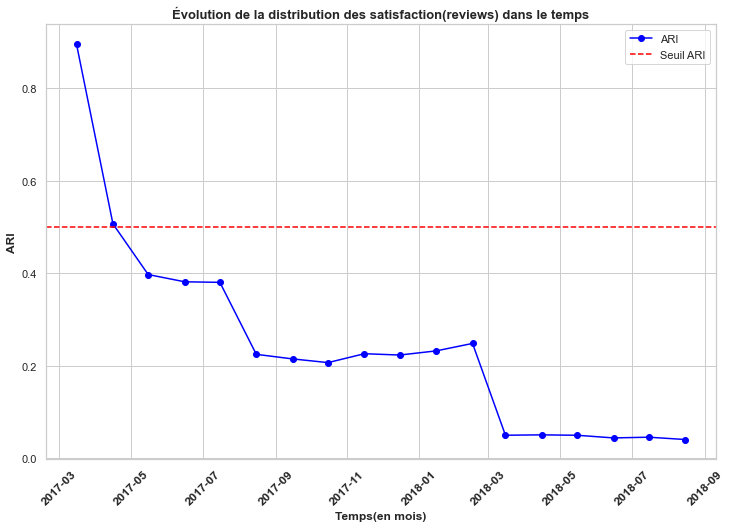

In [187]:
data_clean = data_clean.copy()

# Convertir les timestamps en datetime
data_clean['order_purchase_timestamp'] = pd.to_datetime(data_clean['order_purchase_timestamp'])

# Définir la date de début pour le calculs des reviews
T1 = data_clean['order_purchase_timestamp'].min() + pd.DateOffset(months=6)

# Dictionnaire de temps pour le tracé
temps = {i: T1 + pd.DateOffset(months = i) for i in range(19)}

# Filtrer les données initiales pour inclure les commandes jusqu'à T0 inclus
initial_data = data_clean[data_clean['order_purchase_timestamp'] <= T1]

df_reviews = initial_data.groupby('customer_unique_id').agg({
            'order_purchase_timestamp': lambda x: (current_date - x.max()).days,  # Récence
            'order_id': 'count',  # Fréquence
            'price': 'sum',  # Montant
            'review_score': 'mean'
    }).rename(columns={'order_purchase_timestamp': 'Recency',
                   'order_id': 'Frequency',
                   'price': 'MonetaryValue',
                   'review_score': 'Review_scores'})
# Normaliser les données reviews
scaler = StandardScaler()
reviews_normalized = scaler.fit_transform(df_reviews[['Recency', 'Frequency', 'MonetaryValue','Review_scores']])

# Clustering initial avec K-Means
kmeans_reviews = KMeans(n_clusters=5, random_state=42)
M1 = kmeans_reviews.fit(reviews_normalized)
df_reviews['Cluster_reviews'] = M1.labels_

# Boucle temporelle pour les calculs et ARI
end_date = data_clean['order_purchase_timestamp'].max()
current_date = T1
aris_review = []
time_labels = []


while current_date <= end_date:
    # Enregistrement de la date courante pour l'étiquette
    month_index = (current_date - T1).days // 30  # Calcul de l'index du mois
    time_labels.append(temps.get(month_index, current_date))
    
    next_month = current_date + pd.DateOffset(days=30)
    month_data = data_clean[data_clean['order_purchase_timestamp'] <= next_month]
    current_reviews = month_data.groupby('customer_unique_id').agg({
            'order_purchase_timestamp': lambda x: (current_date - x.max()).days,  # Récence
            'order_id': 'count',  # Fréquence
            'price': 'sum',  # Montant
            'review_score': 'mean'
    
}).rename(columns={'order_purchase_timestamp': 'Recency',
                   'order_id': 'Frequency',
                   'price': 'MonetaryValue',
                   'review_score': 'Review_scores'})

    if not current_reviews.empty:
        current_reviews_normalized = scaler.transform(current_reviews[['Recency', 'Frequency', 'MonetaryValue','Review_scores']])       
        model1 = KMeans(n_clusters=5, random_state=42)
        Mi = model1.fit(current_reviews_normalized)
        Ci_new = Mi.labels_
        Ci_init = M1.predict(current_reviews_normalized)
        
        # Calcul de ARI
        ari = adjusted_rand_score(Ci_new, Ci_init)
        aris_review.append(ari)
    
    current_date += pd.DateOffset(days=30)

# Afficher le graphique de l'ARI
plt.figure(figsize=(12, 8))
plt.plot(time_labels, aris_review, marker='o', color="blue", label='ARI')
plt.axhline(y=0.5, color='red', linestyle='--', label='Seuil ARI')
plt.xlabel('Temps(en mois)', fontweight='bold', fontsize=12)
plt.ylabel('ARI', fontweight='bold', fontsize=12)
plt.title('Évolution de la distribution des satisfaction(reviews) dans le temps', fontweight='bold', fontsize=13)
plt.xticks(rotation=45,fontweight='bold', fontsize=12) 
plt.legend()
plt.grid(True)
plt.show()

#

# Contrat de Maintenance des Modèles  

#

**Entre** : Global Consulting

**Adresse** : France

**Représenté par** : Cedric Gassuc

**Fonction** : consultant data scientiste
#    
 
**Et** :  Olist

**Adresse** : Entreprise brésilienne

**Représenté** par :Fernanda

**Fonction** : Lead Data Analyst chez Olist

##   

**Préambule :**
Ce contrat vise à établir les termes et conditions sous lesquels Global Consulting fournira des services de maintenance 
régulière et des mises à jour des modèles de clustering utilisés par Olist pour assurer une 
segmentation efficace de la clientèle et une prise de décision optimisée.


**1. Objet du contrat**
Le présent contrat a pour objet de définir les conditions selon lesquelles Global Consulting s'engage à effectuer la maintenance 
et l'optimisation des modèles de clustering basés sur l'évaluation périodique de l'ARI, pour garantir leur efficacité et 
précision.

**2. Durée du contrat**
Le présent contrat est conclu pour une durée initiale de 3 ans à compter de la date de signature. Il est renouvelable 
par tacite reconduction sauf résiliation par l'une des parties avec un préavis de 6 mois.

**3. Services de maintenance**

**3.1 Surveillance continue** : Global Consulting effectuera une surveillance mensuelle de l'ARI pour détecter toute divergence significative dans les résultats de clustering.

**3.2 Interventions de maintenance** : En cas de chute de l'ARI en dessous du seuil de 0,5, Global Consulting s'engage à :

Analyser les causes potentielles de la divergence.
Réajuster ou réentraîner les modèles avec les nouvelles données ou paramètres modifiés.
Valider et déployer le modèle ajusté pour assurer la continuité des opérations.

**4. Fréquence des révisions**
Des révisions planifiées du modèle seront réalisées semestriellement pour anticiper les ajustements nécessaires indépendamment
des résultats de l'ARI.

**5. Rapport et communication**
Global Consulting fournira un rapport détaillé après chaque intervention et révision, comprenant l'analyse de performance, les actions 
entreprises, et les recommandations pour les périodes suivantes.

**6. Coût des services**

**6.1 Frais de maintenance régulière** : 10000 euros payable annuellement.

**6.2 Interventions supplémentaires** : Facturées selon un tarif horaire de 200 euros pour le temps passé au-delà des 
interventions planifiées.

**7. Confidentialité**
Les deux parties s'engagent à maintenir la confidentialité des données et des informations échangées dans le cadre de ce 
contrat.

**8. Dispositions finales**
En cas de litige, les parties s'engagent à rechercher une solution amiable avant toute action judiciaire.


######  
Signature du représentant de: Global Consulting

Cedric , consultant data scientiste 

Signature du représentant de: Olist

Fernanda, Lead Data Analyst chez Olist
